# *Salary Prediction and Bias Analysis*

Análise de dados salariais da base de dados do governo brasileiro Relação Anual de Informações Sociais (RAIS). Especificamente, esses são dados referentes ao estado de São Paulo do ano de 2019.

A proposta desse projeto é realizar uma análise do padrão salarial dos funcionários da área da computação, procurar por possíveis disparidades e viéses existentes e verificar se tais disparidades são presentes em um possível modelo de predição salarial. São usados no modelo tanto dados de cunho técnico, como nível de escolaridade, quanto dados de cunho social, como raça e sexo.

A preocupação dessa análise com os dados da RAIS NÃO É obter uma precisão alta em um modelo preditivo. A proposta com esses dados é realizar a análise de viés salarial (discriminação salarial), enquanto a predição salarial em si fica com outros *datasets*.

## Bases estatísticas para estudo

FARIAS, Alfredo Alves de; SOARES, José Francisco; CÉSAR, Cibele Comini. Introdução à estatística. 2. ed. Rio de Janeiro: LTC - Livros Técnicos e Científicos, c2003. xiii, 340 p. ISBN 8521612931.

TRIOLA, Mario F. Introdução à estatística. 12. ed. Rio de Janeiro: LTC - Livros Técnicos e Científicos, c2017. E-book. ISBN 9788521634256.

## Base em Python

### Bibliotecas

SciPy, Sklearn, Pytorch, Pyspark, Pandas, Matplotlib, Seaborn

### Links úteis

Tabela completa CBO: https://www.ocupacoes.com.br/tabela-completa-da-cbo

Tabela completa CNAE: https://concla.ibge.gov.br/busca-online-cnae.html?view=secao&tipo=cnae&versaosubclasse=10&versaoclasse=7&secao=J

## Coisas a fazer

Revisar testes de normalidade e de hipótese

Avaliar distribuição de salários por idade (histograma de salários por faixas etárias (X = faixas, Y = salários))

Adicionar à tabela de combinações de fatores sociais algo associado à idade

# Preparos básicos

## Imports

In [ ]:
# visualization

  # matplotlib

import matplotlib as m
import matplotlib.pyplot as plt

  # matplotlib styles

from pylab import rcParams

plt.style.use('fivethirtyeight')

m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['axes.labelsize'] = 14

rcParams['figure.figsize'] = 16, 8

%matplotlib inline

  # seaborn

import seaborn as sns

# numbers

  # numpy

import numpy as np

# data

  # get data

    # colab

from google.colab import drive

  # big data

    # pyspark dependencies

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

from pyspark.sql.functions import col, regexp_replace, trim, lit, when

from functools import reduce

  # filtered data

    # pandas

import pandas as pd

# normality tests

  # shapiro-wilk and kolmogorov-smirnov

from scipy.stats import shapiro, kstest

# hypothesis tests

  # mann-whitney u

import scipy.stats as stats

# models

  # prepocessing

!pip install category_encoders

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders.cat_boost import CatBoostEncoder

  # model evaluations

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

  # classification statistical models

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

  # regression statistical models

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.4 MB/s eta 0:00:00


## Montagem do drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Preparos para carregamento dos dados

In [ ]:
COL_NAMES = (
    "bairros_sp", "bairros_fortaleza", "bairros_rj",
    "causa_afastamento_1", "causa_afastamento_2", "causa_afastamento_3",
    "Motivo_Desligamento", "cbo_ocupacao_2002", "cnae_20_classe", "cnae_95_classe",
    "distritos_sp", "vinculo_ativo_31_12", "faixa_etaria", "faixa_hora_contrat",
    "faixa_remun_dezem_sm", "faixa_remun_media_sm", "faixa_tempo_emprego",
    "escolaridade_apos_2005", "qtd_hora_contr", "idade", "ind_cei_vinculado",
    "ind_simples", "mes_admissao", "mes_desligamento", "mun_trab", "municipio",
    "nacionalidade", "natureza_juridica", "ind_portador_defic", "qtd_dias_afastamento",
    "raca_cor", "regioes_adm_df", "vl_remun_dezembro_nom", "vl_remun_dezembro_sm",
    "vl_remun_media_nom", "vl_remun_media_sm", "cnae_20_subclasse", "sexo_trabalhador",
    "tamanho_estabelecimento", "tempo_emprego", "tipo_admissao", "tipo_estab1", "tipo_estab2",
    "tipo_defic", "tipo_vinculo", "ibge_subsetor", "vl_rem_janeiro_cc", "vl_rem_fevereiro_cc",
    "vl_rem_marco_cc", "vl_rem_abril_cc", "vl_rem_maio_cc", "vl_rem_junho_cc", "vl_rem_julho_cc",
    "vl_rem_agosto_cc", "vl_rem_setembro_cc", "vl_rem_outubro_cc", "vl_rem_novembro_cc",
    "ano_chegada_brasil", "ind_trab_intermitente", "ind_trab_parcial"
)

file_path = "drive/MyDrive/catholic/article/microdados/"

# Pré-processamento e análise dos dados em pyspark

## Pré-processamento

### Carregar dados no pypark

In [ ]:
df = spark.read.csv(file_path+"RAIS_VINC_PUB_SP.csv", sep=";", multiLine=True, inferSchema=True)

### Tratar nome das colunas

In [ ]:
old_columns = df.schema.names

df = reduce(lambda df, i: df.withColumnRenamed(old_columns[i], COL_NAMES[i]),
            range(len(old_columns)), df)

df.printSchema()

root
 |-- bairros_sp: string (nullable = true)
 |-- bairros_fortaleza: string (nullable = true)
 |-- bairros_rj: string (nullable = true)
 |-- causa_afastamento_1: string (nullable = true)
 |-- causa_afastamento_2: string (nullable = true)
 |-- causa_afastamento_3: string (nullable = true)
 |-- Motivo_Desligamento: string (nullable = true)
 |-- cbo_ocupacao_2002: string (nullable = true)
 |-- cnae_20_classe: string (nullable = true)
 |-- cnae_95_classe: string (nullable = true)
 |-- distritos_sp: string (nullable = true)
 |-- vinculo_ativo_31_12: string (nullable = true)
 |-- faixa_etaria: string (nullable = true)
 |-- faixa_hora_contrat: string (nullable = true)
 |-- faixa_remun_dezem_sm: string (nullable = true)
 |-- faixa_remun_media_sm: string (nullable = true)
 |-- faixa_tempo_emprego: string (nullable = true)
 |-- escolaridade_apos_2005: string (nullable = true)
 |-- qtd_hora_contr: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- ind_cei_vinculado: string (null

In [ ]:
df.head(2)

[Row(bairros_sp='Bairros SP', bairros_fortaleza='Bairros Fortaleza', bairros_rj='Bairros RJ', causa_afastamento_1='Causa Afastamento 1', causa_afastamento_2='Causa Afastamento 2', causa_afastamento_3='Causa Afastamento 3', Motivo_Desligamento='Motivo Desligamento', cbo_ocupacao_2002='CBO Ocupa��o 2002', cnae_20_classe='CNAE 2.0 Classe', cnae_95_classe='CNAE 95 Classe', distritos_sp='Distritos SP', vinculo_ativo_31_12='V�nculo Ativo 31/12', faixa_etaria='Faixa Et�ria', faixa_hora_contrat='Faixa Hora Contrat', faixa_remun_dezem_sm='Faixa Remun Dezem (SM)', faixa_remun_media_sm='Faixa Remun M�dia (SM)', faixa_tempo_emprego='Faixa Tempo Emprego', escolaridade_apos_2005='Escolaridade ap�s 2005', qtd_hora_contr='Qtd Hora Contr', idade='Idade', ind_cei_vinculado='Ind CEI Vinculado', ind_simples='Ind Simples', mes_admissao='M�s Admiss�o', mes_desligamento='M�s Desligamento', mun_trab='Mun Trab', municipio='Munic�pio', nacionalidade='Nacionalidade', natureza_juridica='Natureza Jur�dica', ind_po

### Tratamento básico das strings

#### Substituir vírgulas por ponto

In [ ]:
df = df.withColumn('vl_remun_media_nom', regexp_replace(df.vl_remun_media_sm, ',', '.'))
df = df.withColumn('vl_remun_media_sm', regexp_replace(df.vl_remun_media_sm, ',', '.'))

df = df.withColumn('vl_remun_dezembro_nom', regexp_replace(df.vl_remun_dezembro_nom, ',', '.'))
df = df.withColumn('vl_remun_dezembro_sm', regexp_replace(df.vl_remun_dezembro_sm, ',', '.'))

df = df.withColumn('vl_rem_janeiro_cc', regexp_replace(df.vl_rem_janeiro_cc, ',', '.'))
df = df.withColumn('vl_rem_fevereiro_cc', regexp_replace(df.vl_rem_fevereiro_cc, ',', '.'))
df = df.withColumn('vl_rem_marco_cc', regexp_replace(df.vl_rem_marco_cc, ',', '.'))
df = df.withColumn('vl_rem_abril_cc', regexp_replace(df.vl_rem_abril_cc, ',', '.'))
df = df.withColumn('vl_rem_maio_cc', regexp_replace(df.vl_rem_maio_cc, ',', '.'))
df = df.withColumn('vl_rem_junho_cc', regexp_replace(df.vl_rem_junho_cc, ',', '.'))
df = df.withColumn('vl_rem_julho_cc', regexp_replace(df.vl_rem_julho_cc, ',', '.'))
df = df.withColumn('vl_rem_agosto_cc', regexp_replace(df.vl_rem_agosto_cc, ',', '.'))
df = df.withColumn('vl_rem_setembro_cc', regexp_replace(df.vl_rem_setembro_cc, ',', '.'))
df = df.withColumn('vl_rem_outubro_cc', regexp_replace(df.vl_rem_outubro_cc, ',', '.'))
df = df.withColumn('vl_rem_novembro_cc', regexp_replace(df.vl_rem_novembro_cc, ',', '.'))

df = df.withColumn('tempo_emprego', regexp_replace(df.tempo_emprego, ',', '.'))

#### Remover \r

In [ ]:
df = df.withColumn('ind_trab_parcial', regexp_replace(df.ind_trab_parcial, '\r', ''))

#### Remover não-ASCII

In [ ]:
#for column in COL_NAMES:
#  df[column] = df[column].str.encode('ascii', 'ignore').str.decode('ascii')

#### Limpar espaços em branco

In [ ]:
df = df.withColumn("tempo_emprego", trim(df.tempo_emprego))
df = df.withColumn("bairros_sp", trim(df.bairros_sp))
df = df.withColumn("bairros_fortaleza", trim(df.bairros_fortaleza))
df = df.withColumn("bairros_rj", trim(df.bairros_rj))
df = df.withColumn("distritos_sp", trim(df.distritos_sp))
df = df.withColumn("escolaridade_apos_2005", trim(df.escolaridade_apos_2005))
df = df.withColumn("qtd_hora_contr", trim(df.qtd_hora_contr))
df = df.withColumn("idade", trim(df.idade))
df = df.withColumn("qtd_dias_afastamento", trim(df.qtd_dias_afastamento))
df = df.withColumn("sexo_trabalhador", trim(df.sexo_trabalhador))
df = df.withColumn("tempo_emprego", trim(df.tempo_emprego))
df = df.withColumn("tipo_estab2", trim(df.tipo_estab2))

#### Remover bairros de Fortaleza e RJ

In [ ]:
cols_to_drop = ["bairros_fortaleza", "bairros_rj"]
df = df.drop(*cols_to_drop)

In [ ]:
df.head(10)

[Row(bairros_sp='Bairros SP', causa_afastamento_1='Causa Afastamento 1', causa_afastamento_2='Causa Afastamento 2', causa_afastamento_3='Causa Afastamento 3', Motivo_Desligamento='Motivo Desligamento', cbo_ocupacao_2002='CBO Ocupa��o 2002', cnae_20_classe='CNAE 2.0 Classe', cnae_95_classe='CNAE 95 Classe', distritos_sp='Distritos SP', vinculo_ativo_31_12='V�nculo Ativo 31/12', faixa_etaria='Faixa Et�ria', faixa_hora_contrat='Faixa Hora Contrat', faixa_remun_dezem_sm='Faixa Remun Dezem (SM)', faixa_remun_media_sm='Faixa Remun M�dia (SM)', faixa_tempo_emprego='Faixa Tempo Emprego', escolaridade_apos_2005='Escolaridade ap�s 2005', qtd_hora_contr='Qtd Hora Contr', idade='Idade', ind_cei_vinculado='Ind CEI Vinculado', ind_simples='Ind Simples', mes_admissao='M�s Admiss�o', mes_desligamento='M�s Desligamento', mun_trab='Mun Trab', municipio='Munic�pio', nacionalidade='Nacionalidade', natureza_juridica='Natureza Jur�dica', ind_portador_defic='Ind Portador Defic', qtd_dias_afastamento='Qtd Dia

### Agrupamento textual por CNAE

In [ ]:
df = df.withColumn("area_atuacao_cnae", lit(None))
df.createOrReplaceTempView("DF")

# filter by informacao
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("58"), "informação") \
              .when(df.cnae_20_classe.startswith("59"), "informação") \
              .when(df.cnae_20_classe.startswith("60"), "informação") \
              .when(df.cnae_20_classe.startswith("61"), "informação") \
              .when(df.cnae_20_classe.startswith("62"), "informação") \
              .when(df.cnae_20_classe.startswith("63"), "informação") \
              .otherwise(df.area_atuacao_cnae))

# filter by saude
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("86"), "saúde") \
              .when(df.cnae_20_classe.startswith("87"), "saúde") \
              .when(df.cnae_20_classe.startswith("88"), "saúde") \
              .otherwise(df.area_atuacao_cnae))

# filter by gestao_residuos
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("36"), "gestão de resíduos") \
              .when(df.cnae_20_classe.startswith("37"), "gestão de resíduos") \
              .when(df.cnae_20_classe.startswith("38"), "gestão de resíduos") \
              .when(df.cnae_20_classe.startswith("39"), "gestão de resíduos") \
              .otherwise(df.area_atuacao_cnae))

# filter by construcao
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("41"), "construção") \
              .when(df.cnae_20_classe.startswith("42"), "construção") \
              .when(df.cnae_20_classe.startswith("43"), "construção") \
              .otherwise(df.area_atuacao_cnae))

# filter by cient_tec
df = df.withColumn("area_atuacao_cnae", when(df.cnae_20_classe.startswith("69"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("70"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("71"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("72"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("73"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("74"), "científicos e tecnologia") \
              .when(df.cnae_20_classe.startswith("75"), "científicos e tecnologia") \
              .otherwise(df.area_atuacao_cnae))
df.filter(df.cnae_20_classe.startswith("58") | df.cnae_20_classe.startswith("59")).show()

+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------------+--------------+------------+-------------------+------------+------------------+--------------------+--------------------+-------------------+----------------------+--------------+-----+-----------------+-----------+------------+----------------+--------+---------+-------------+-----------------+------------------+--------------------+--------+--------------+---------------------+--------------------+------------------+-----------------+-----------------+----------------+-----------------------+-------------+-------------+-----------+-----------+----------+------------+-------------+-----------------+-------------------+---------------+---------------+--------------+---------------+---------------+----------------+------------------+-----------------+------------------+------------------+---------------------+----------------+-----------------+
|bairros_sp|causa_

### Agrupamento textual por CBO

In [ ]:
df = df.withColumn("area_atuacao_cbo", lit(None))
df.createOrReplaceTempView("DF")

# forças armadas
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("0"), "forças armadas") \
              .otherwise(df.area_atuacao_cbo))

# poder público
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("1"), "poder público") \
              .otherwise(df.area_atuacao_cbo))

# ciências e artes (informática inclusa)
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("212"), "ciências e artes") \
              .otherwise(df.area_atuacao_cbo))

# técnicos nível médio
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("3"), "técnicos nível médio") \
              .otherwise(df.area_atuacao_cbo))

# serviços administrativos
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("4"), "serviços administrativos") \
              .otherwise(df.area_atuacao_cbo))

# serviços de comércio
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("5"), "serviços de comércio") \
              .otherwise(df.area_atuacao_cbo))

# serviços rurais
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("6"), "serviços rurais") \
              .otherwise(df.area_atuacao_cbo))

# serviços industriais 1
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("7"), "serviços industriais 1") \
              .otherwise(df.area_atuacao_cbo))

# serviços industriais 2
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("8"), "serviços industriais 2") \
              .otherwise(df.area_atuacao_cbo))

# serviços de manutenção
df = df.withColumn("area_atuacao_cbo", when(df.cbo_ocupacao_2002.startswith("9"), "serviços de manutenção") \
              .otherwise(df.area_atuacao_cbo))

df.filter(df.cbo_ocupacao_2002.startswith("0") | df.cbo_ocupacao_2002.startswith("2")).show()

+----------+-------------------+-------------------+-------------------+-------------------+-----------------+--------------+--------------+------------+-------------------+------------+------------------+--------------------+--------------------+-------------------+----------------------+--------------+-----+-----------------+-----------+------------+----------------+--------+---------+-------------+-----------------+------------------+--------------------+--------+--------------+---------------------+--------------------+------------------+-----------------+-----------------+----------------+-----------------------+-------------+-------------+-----------+-----------+----------+------------+-------------+-----------------+-------------------+---------------+---------------+--------------+---------------+---------------+----------------+------------------+-----------------+------------------+------------------+---------------------+----------------+-----------------+----------------+
|

## Segregações para análise salarial

### Filtro geral

{'whiskers': [<matplotlib.lines.Line2D at 0x7f87cda51540>,
 'caps': [<matplotlib.lines.Line2D at 0x7f87cda51a80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f87cda512a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f87cda51fc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f87cda52260>,
 'means': []}

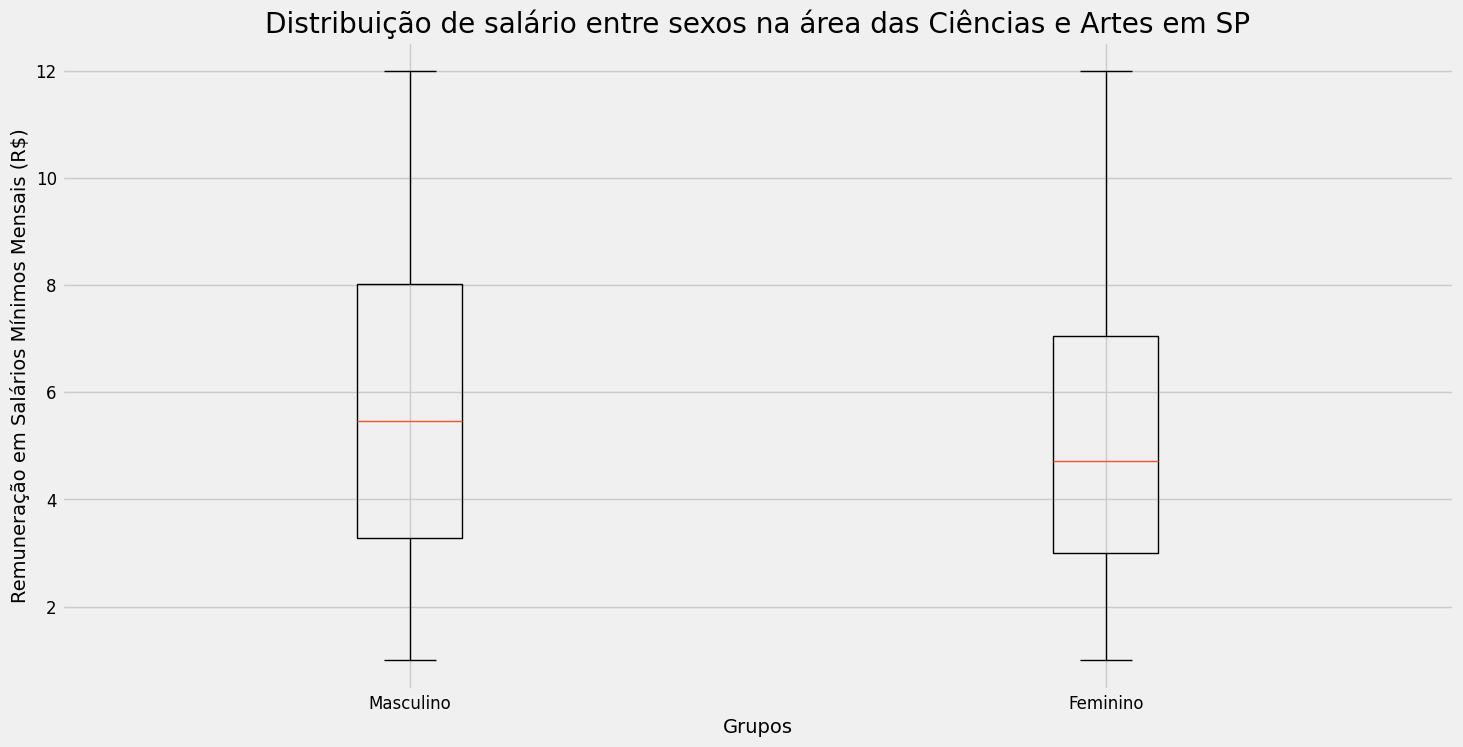

In [ ]:
clt_values = [10, 15, 20, 25, 60, 65, 70, 75]
comp_df = df.filter(df.tipo_vinculo.isin(clt_values))

comp_df = comp_df.filter((comp_df.area_atuacao_cbo == "ciências e artes"))  # funcionário da área de ciências e artes (inclui computação)
comp_df = comp_df.filter(comp_df.area_atuacao_cnae == "informação")  # empresa da área da informática

comp_df = comp_df.filter((comp_df.escolaridade_apos_2005 > 8) & (comp_df.vl_remun_media_sm >= 1) & (comp_df.vl_remun_media_sm < 12) & (comp_df.faixa_etaria >= 3))

df_male = comp_df.filter((comp_df.sexo_trabalhador == 1))
df_female = comp_df.filter((comp_df.sexo_trabalhador == 2))

plt.title("Distribuição de salário entre sexos na área das Ciências e Artes em SP")
plt.ylabel("Remuneração em Salários Mínimos Mensais (R$)")
plt.xlabel("Grupos")

male_data = df_male.select("vl_remun_media_sm").toPandas()
female_data = df_female.select("vl_remun_media_sm").toPandas()

datam = pd.to_numeric(male_data['vl_remun_media_sm'], downcast="float")
dataf = pd.to_numeric(female_data['vl_remun_media_sm'], downcast="float")

plt.boxplot([datam, dataf], labels=["Masculino", "Feminino"])

### Segregações não exclusivas

#### Homens e mulheres PPI

In [ ]:
df_m_ppi = df_male.filter(((df_male.raca_cor == 1) | (df_male.raca_cor == 4) | (df_male.raca_cor == 8)))
df_f_ppi = df_female.filter(((df_female.raca_cor == 1) | (df_female.raca_cor == 4) | (df_female.raca_cor == 8)))

datapm_data = df_m_ppi.select("vl_remun_media_sm").toPandas()
datapf_data = df_f_ppi.select("vl_remun_media_sm").toPandas()

datapm = pd.to_numeric(datapm_data['vl_remun_media_sm'], downcast="float")
datapf = pd.to_numeric(datapf_data['vl_remun_media_sm'], downcast="float")

#### Homens e mulheres não-PPI

In [ ]:
df_m_nppi = df_male.filter(((df_male.raca_cor == 2) | (df_male.raca_cor == 6)))
df_f_nppi = df_female.filter(((df_female.raca_cor == 2) | (df_female.raca_cor == 6)))

datanpm_data = df_m_nppi.select("vl_remun_media_sm").toPandas()
datanpf_data = df_f_nppi.select("vl_remun_media_sm").toPandas()

datanpm = pd.to_numeric(datanpm_data['vl_remun_media_sm'], downcast="float")
datanpf = pd.to_numeric(datanpf_data['vl_remun_media_sm'], downcast="float")

#### Homens e mulheres PCD

In [ ]:
df_m_pcd = df_male.filter((df_male.ind_portador_defic == 1))
df_f_pcd = df_female.filter((df_female.ind_portador_defic == 1))

datadm_data = df_m_pcd.select("vl_remun_media_sm").toPandas()
datadf_data = df_f_pcd.select("vl_remun_media_sm").toPandas()

datadm = pd.to_numeric(datadm_data['vl_remun_media_sm'], downcast="float")
datadf = pd.to_numeric(datadf_data['vl_remun_media_sm'], downcast="float")

#### Homens e mulheres não-PCD

In [ ]:
df_m_npcd = df_male.filter((df_male.ind_portador_defic == 0))
df_f_npcd = df_female.filter((df_female.ind_portador_defic == 0))

datandm_data = df_m_npcd.select("vl_remun_media_sm").toPandas()
datandf_data = df_f_npcd.select("vl_remun_media_sm").toPandas()

datandm = pd.to_numeric(datandm_data['vl_remun_media_sm'], downcast="float")
datandf = pd.to_numeric(datandf_data['vl_remun_media_sm'], downcast="float")

### Segregações exclusivas

#### M, N-PCD, N-PPI - Índice 0

In [ ]:
# M, N-PCD, N-PPI - Índice 0

i0 = df_male.filter((df_male.ind_portador_defic == 0) & ((df_male.raca_cor == 2) |
                                                                     (df_male.raca_cor == 6)))

i0_data = i0.select("vl_remun_media_sm").toPandas()
i0_data = pd.to_numeric(i0_data['vl_remun_media_sm'], downcast="float")

#### M, N-PCD, PPI - Índice 1

In [ ]:
# M, N-PCD, PPI - Índice 1

i1 = df_male.filter((df_male.ind_portador_defic == 0) & ((df_male.raca_cor == 1) |
                                                                     (df_male.raca_cor == 4) |
                                                                     (df_male.raca_cor == 8)))

i1_data = i1.select("vl_remun_media_sm").toPandas()
i1_data = pd.to_numeric(i1_data['vl_remun_media_sm'], downcast="float")

#### M, PCD, N-PPI - Índice 2

In [ ]:
# M, PCD, N-PPI - Índice 2

i2 = df_male.filter((df_male.ind_portador_defic == 1) & ((df_male.raca_cor == 2) |
                                                                     (df_male.raca_cor == 6)))

i2_data = i2.select("vl_remun_media_sm").toPandas()
i2_data = pd.to_numeric(i2_data['vl_remun_media_sm'], downcast="float")

#### M, PCD, PPI - Índice 3

In [ ]:
# M, PCD, PPI - Índice 3

i3 = df_male.filter((df_male.ind_portador_defic == 1) & ((df_male.raca_cor == 1) |
                                                                     (df_male.raca_cor == 4) |
                                                                     (df_male.raca_cor == 8)))

i3_data = i3.select("vl_remun_media_sm").toPandas()
i3_data = pd.to_numeric(i3_data['vl_remun_media_sm'], downcast="float")

#### F, N-PCD, N-PPI - Índice 4

In [ ]:
# F, N-PCD, N-PPI - Índice 4

i4 = df_female.filter((df_female.ind_portador_defic == 0) & ((df_female.raca_cor == 2) |
                                                                     (df_female.raca_cor == 6)))

i4_data = i4.select("vl_remun_media_sm").toPandas()
i4_data = pd.to_numeric(i4_data['vl_remun_media_sm'], downcast="float")

#### F, N-PCD, PPI - Índice 5

In [ ]:
# F, N-PCD, PPI - Índice 5

i5 = df_female.filter((df_female.ind_portador_defic == 0) & ((df_female.raca_cor == 1) |
                                                                     (df_female.raca_cor == 4) |
                                                                     (df_female.raca_cor == 8)))

i5_data = i5.select("vl_remun_media_sm").toPandas()
i5_data = pd.to_numeric(i5_data['vl_remun_media_sm'], downcast="float")

#### F, PCD, N-PPI - Índice 6

In [ ]:
# F, PCD, N-PPI - Índice 6

i6 = df_female.filter((df_female.ind_portador_defic == 1) & ((df_female.raca_cor == 2) |
                                                                     (df_female.raca_cor == 6)))

i6_data = i6.select("vl_remun_media_sm").toPandas()
i6_data = pd.to_numeric(i6_data['vl_remun_media_sm'], downcast="float")

#### F, PCD, PPI - Índice 7

In [ ]:
# F, PCD, PPI - Índice 7

i7 = df_female.filter((df_female.ind_portador_defic == 1) & ((df_female.raca_cor == 1) |
                                                                     (df_female.raca_cor == 4) |
                                                                     (df_female.raca_cor == 8)))

i7_data = i7.select("vl_remun_media_sm").toPandas()
i7_data = pd.to_numeric(i7_data['vl_remun_media_sm'], downcast="float")

### Gráfico comparativo

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0c3dcdd840>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0c3dcdd300>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0c3dcddae0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0c3dcdcdc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0c3dcdcb20>,
 'means': []}

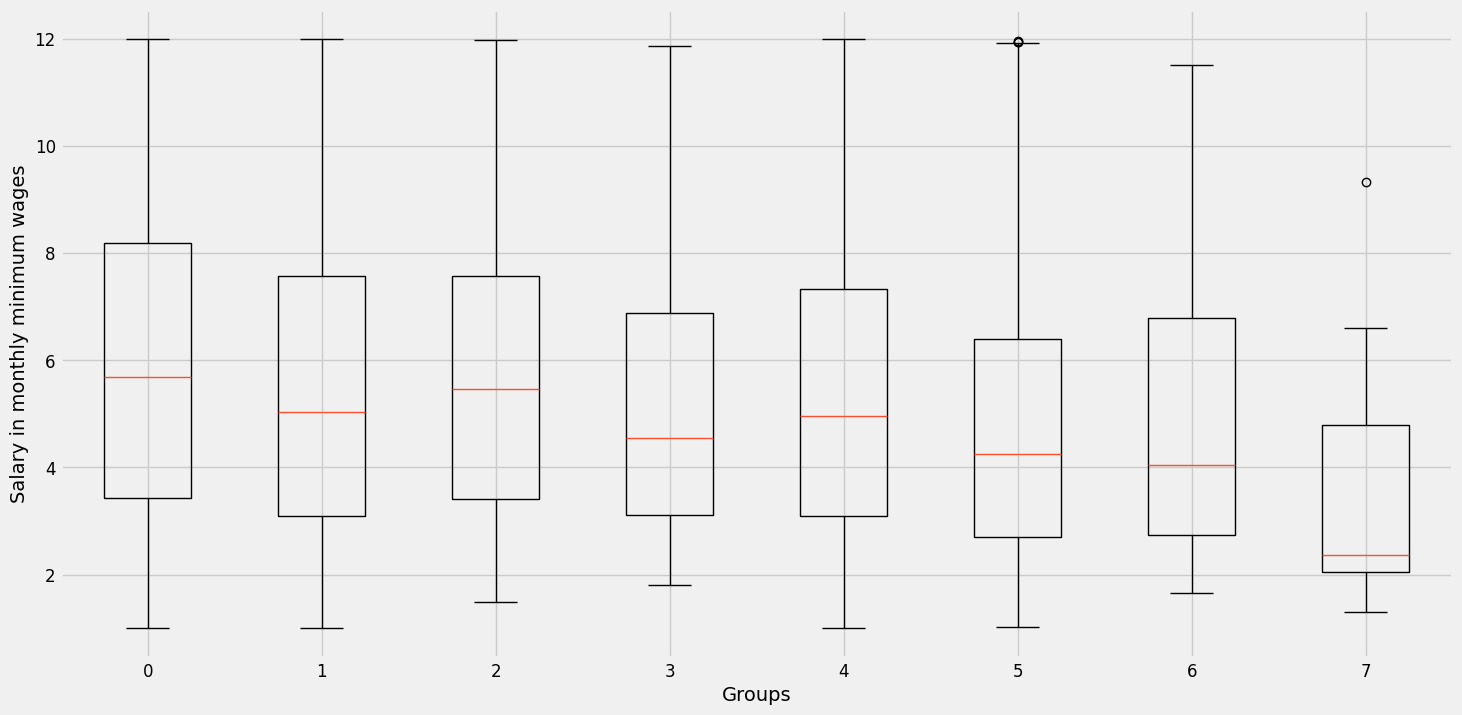

In [ ]:
plt.ylabel("Salary in monthly minimum wages")
plt.xlabel("Groups")

plt.boxplot([i0_data, i1_data, i2_data, i3_data,
             i4_data, i5_data, i6_data, i7_data], labels=["0", "1", "2", "3", "4", "5", "6", "7"])

In [ ]:
x = np.arange(len(['18-24', '25-29', '30-39', '40-49', '50-64', "65+"]))

In [ ]:
labels = ['PPI', 'NÃO-PPI', 'PCD', 'NÃO-PCD', 'GERAL']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Homens')
rects2 = ax.bar(x + width/2, women_means, width, label='Mulheres')

ax.set_ylabel('Média salarial')
ax.set_title('Distribuição salarial por sexo e faixa etária')
ax.set_xticks(x, tuple(['18-24', '25-29', '30-39', '40-49', '50-64', "65+"]))
ax.legend()

fig.tight_layout()

plt.show()

### Fator social e seus impactos no salário

In [ ]:
# i0_data, i1_data, i2_data, i3_data,
# i4_data, i5_data, i6_data, i7_data

i0_data_mean = i0_data.mean()
i1_data_mean = i1_data.mean()
i2_data_mean = i2_data.mean()
i3_data_mean = i3_data.mean()
i4_data_mean = i4_data.mean()
i5_data_mean = i5_data.mean()
i6_data_mean = i6_data.mean()
i7_data_mean = i7_data.mean()

print("Means by indices")
print()
print("Index 0 mean (in minimun wages):", i0_data_mean)
print("Index 1 mean (in minimun wages):", i1_data_mean)
print("Index 2 mean (in minimun wages):", i2_data_mean)
print("Index 3 mean (in minimun wages):", i3_data_mean)
print("Index 4 mean (in minimun wages):", i4_data_mean)
print("Index 5 mean (in minimun wages):", i5_data_mean)
print("Index 6 mean (in minimun wages):", i6_data_mean)
print("Index 7 mean (in minimun wages):", i7_data_mean)
print()

i0_data_median = i0_data.median()
i1_data_median = i1_data.median()
i2_data_median = i2_data.median()
i3_data_median = i3_data.median()
i4_data_median = i4_data.median()
i5_data_median = i5_data.median()
i6_data_median = i6_data.median()
i7_data_median = i7_data.median()

print("Median by indices")
print()
print("Index 0 median (in minimun wages):", i0_data_median)
print("Index 1 median (in minimun wages):", i1_data_median)
print("Index 2 median (in minimun wages):", i2_data_median)
print("Index 3 median (in minimun wages):", i3_data_median)
print("Index 4 median (in minimun wages):", i4_data_median)
print("Index 5 median (in minimun wages):", i5_data_median)
print("Index 6 median (in minimun wages):", i6_data_median)
print("Index 7 median (in minimun wages):", i7_data_median)
print()

biggest_mean = max((i0_data_mean, i1_data_mean, i2_data_mean, i3_data_mean, i4_data_mean, i5_data_mean, i6_data_mean, i7_data_mean))
biggest_median = max((i0_data_median, i1_data_median, i2_data_median, i3_data_median, i4_data_median, i5_data_median, i6_data_median, i7_data_median))

ratio_i0_mean = i0_data_mean / biggest_mean
ratio_i1_mean = i1_data_mean / biggest_mean
ratio_i2_mean = i2_data_mean / biggest_mean
ratio_i3_mean = i3_data_mean / biggest_mean
ratio_i4_mean = i4_data_mean / biggest_mean
ratio_i5_mean = i5_data_mean / biggest_mean
ratio_i6_mean = i6_data_mean / biggest_mean
ratio_i7_mean = i7_data_mean / biggest_mean

print("Ratios by indices / biggest mean")
print()
print("Index 0 mean ratio:", ratio_i0_mean)
print("Index 1 mean ratio:", ratio_i1_mean)
print("Index 2 mean ratio:", ratio_i2_mean)
print("Index 3 mean ratio:", ratio_i3_mean)
print("Index 4 mean ratio:", ratio_i4_mean)
print("Index 5 mean ratio:", ratio_i5_mean)
print("Index 6 mean ratio:", ratio_i6_mean)
print("Index 7 mean ratio:", ratio_i7_mean)
print()

ratio_i0_median = i0_data_median / biggest_median
ratio_i1_median = i1_data_median / biggest_median
ratio_i2_median = i2_data_median / biggest_median
ratio_i3_median = i3_data_median / biggest_median
ratio_i4_median = i4_data_median / biggest_median
ratio_i5_median = i5_data_median / biggest_median
ratio_i6_median = i6_data_median / biggest_median
ratio_i7_median = i7_data_median / biggest_median

print("Ratios by indices / biggest median")
print()
print("Index 0 median ratio:", ratio_i0_median)
print("Index 1 median ratio:", ratio_i1_median)
print("Index 2 median ratio:", ratio_i2_median)
print("Index 3 median ratio:", ratio_i3_median)
print("Index 4 median ratio:", ratio_i4_median)
print("Index 5 median ratio:", ratio_i5_median)
print("Index 6 median ratio:", ratio_i6_median)
print("Index 7 median ratio:", ratio_i7_median)

Means by indices

Index 0 mean (in minimun wages): 5.9232316
Index 1 mean (in minimun wages): 5.470238
Index 2 mean (in minimun wages): 5.7317133
Index 3 mean (in minimun wages): 5.2869515
Index 4 mean (in minimun wages): 5.393808
Index 5 mean (in minimun wages): 4.7678466
Index 6 mean (in minimun wages): 4.9309373
Index 7 mean (in minimun wages): 3.3765626

Median by indices

Index 0 median (in minimun wages): 5.68
Index 1 median (in minimun wages): 5.03
Index 2 median (in minimun wages): 5.47
Index 3 median (in minimun wages): 4.5550003
Index 4 median (in minimun wages): 4.95
Index 5 median (in minimun wages): 4.25
Index 6 median (in minimun wages): 4.04
Index 7 median (in minimun wages): 2.365

Ratios by indices / biggest mean

Index 0 mean ratio: 1.0
Index 1 mean ratio: 0.9235226
Index 2 mean ratio: 0.96766657
Index 3 mean ratio: 0.8925789
Index 4 mean ratio: 0.9106191
Index 5 mean ratio: 0.8049401
Index 6 mean ratio: 0.8324742
Index 7 mean ratio: 0.5700541

Ratios by indices / big

### Resultados

Antes de mostrar os resultados, é necessário explicar como ele será disposto.

#### Disposição dos resultados

O resultado esperado será baseado na análise da seguinte tabela:

|Índice | Sexo | Deficiência | Raça |
|:-----:|:----:|:-----------:|:----:|
|   0   |   0  |      0      |   0  |
|   1   |   0  |      0      |   1  |
|   2   |   0  |      1      |   0  |
|   3   |   0  |      1      |   1  |
|   4   |   1  |      0      |   0  |
|   5   |   1  |      0      |   1  |
|   6   |   1  |      1      |   0  |
|   7   |   1  |      1      |   1  |

Em que:

Sexo = 0 significa Homem e Sexo = 1 significa Mulher;

Deficiência = 0 significa Não-PCD e Deficiência = 1 significa PCD;

Raça = 0 significa Não-PPI e Raça = 1 significa PPI.

Nessa tabela, são contempladas, dos índices 0 ao 7, todas as combinações possíveis de segregação social dentro dos parâmetros avaliados: sexo, deficiência e raça.

#### *Insights*
Nos grupos femininos, há muitos outliers em relação a salarios altos. É importante removermos esses outliers para subir a precisão do modelo.

Baseando-se nos boxplots gerados com cada segregação isolada dessa tabela, temos, em ordem de grupo mais prejudicado para menos prejudicado:

1.   Mulher PCD e PPI (Índice 7)
2.   Mulher não-PCD e PPI* (Índice 5)
3.   Homem PCD e PPI* (Índice 3)
4.   Mulher PCD e não-PPI (Índice 6)
5.   Mulher não-PCD e não-PPI (Índice 4)
6.   Homem não-PCD e PPI (Índice 1)
7.   Homem PCD e não-PPI (Índice 2)
8.   Homem não-PCD e não-PPI (Índice 0)

\* Índice 5 e Índice 3 são muito próximos, porém, o Índice 5 possui um terceiro quartil levemente mais baixo.

## Gráficos gerais


### Carregamento dos dados

In [ ]:
labels = ['PPI', 'NÃO-PPI', 'PCD', 'NÃO-PCD', 'GERAL']
men_means = [
    datapm.mean(),
    datanpm.mean(),
    datadm.mean(),
    datandm.mean(),
    datam.mean()
]
women_means = [
    datapf.mean(),
    datanpf.mean(),
    datadf.mean(),
    datandf.mean(),
    dataf.mean()
]

men_medians = [
    datapm.median(),
    datanpm.median(),
    datadm.median(),
    datandm.median(),
    datam.median()
]
women_medians = [
    datapf.median(),
    datanpf.median(),
    datadf.median(),
    datandf.median(),
    dataf.median()
]

men_std = [
    datapm.std(),
    datanpm.std(),
    datadm.std(),
    datandm.std(),
    datam.std()
]
women_std = [
    datapf.std(),
    datanpf.std(),
    datadf.std(),
    datandf.std(),
    dataf.std()
]



### Gráfico de médias

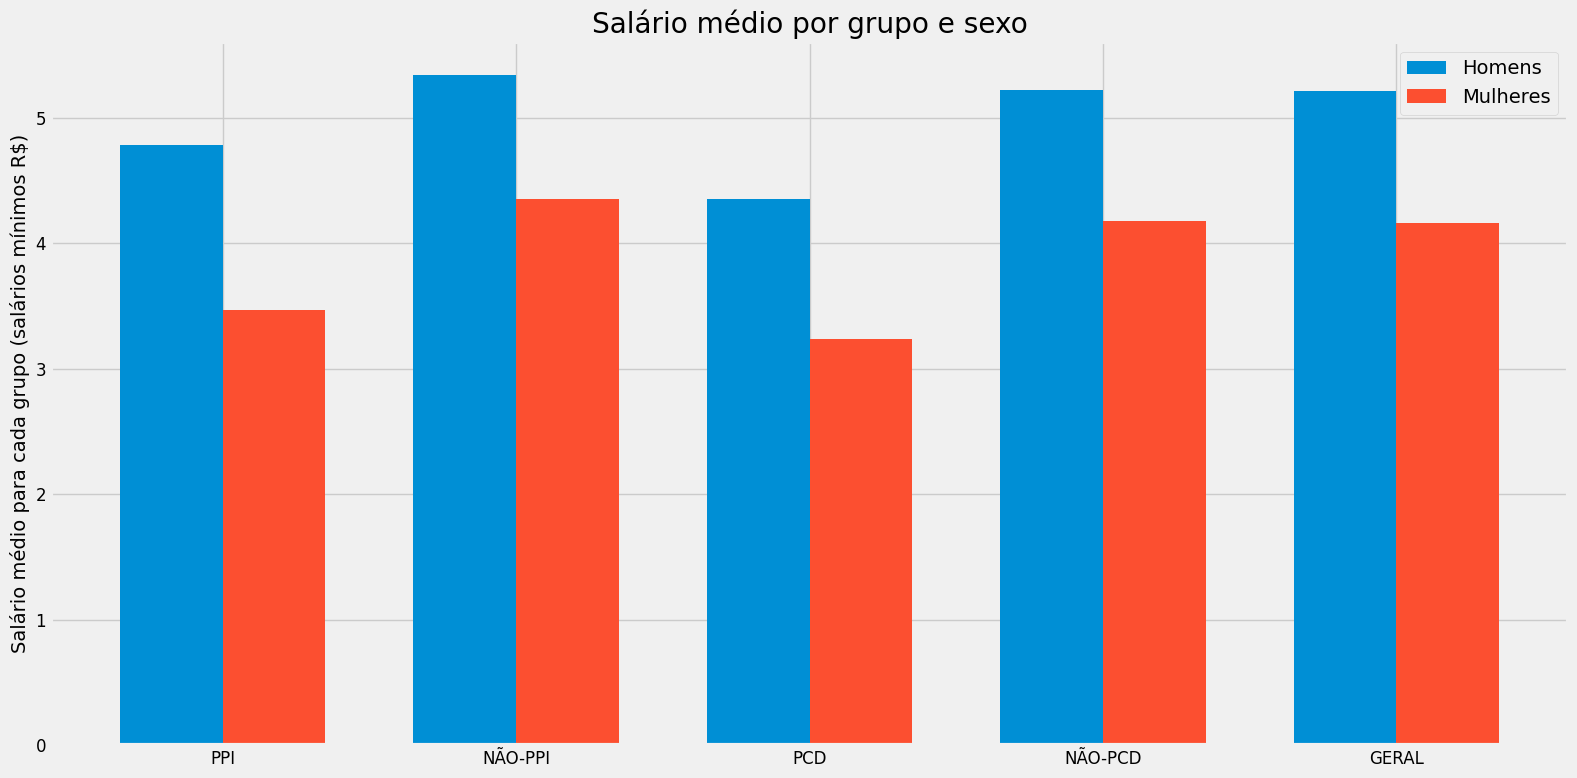

In [ ]:
labels = ['PPI', 'NÃO-PPI', 'PCD', 'NÃO-PCD', 'GERAL']
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Homens')
rects2 = ax.bar(x + width/2, women_means, width, label='Mulheres')

ax.set_ylabel('Salário médio para cada grupo (salários mínimos R$)')
ax.set_title('Salário médio por grupo e sexo')
ax.set_xticks(x, tuple(['PPI', 'NÃO-PPI', 'PCD', 'NÃO-PCD', 'GERAL']))
ax.legend()

fig.tight_layout()

plt.show()

### Gráfico de medianas

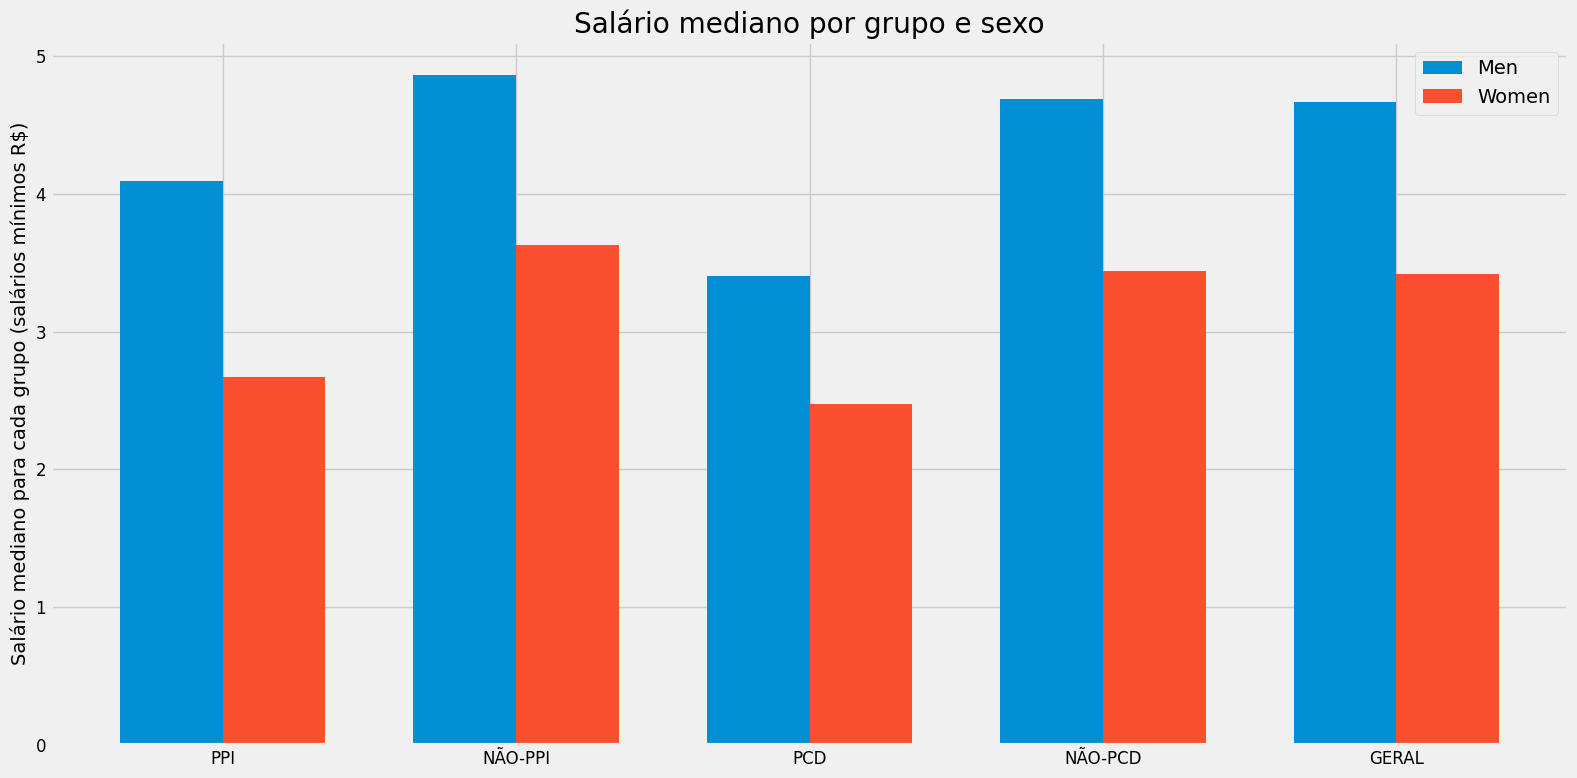

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_medians, width, label='Men')
rects2 = ax.bar(x + width/2, women_medians, width, label='Women')

ax.set_ylabel('Salário mediano para cada grupo (salários mínimos R$)')
ax.set_title('Salário mediano por grupo e sexo')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Gráfico de desvios

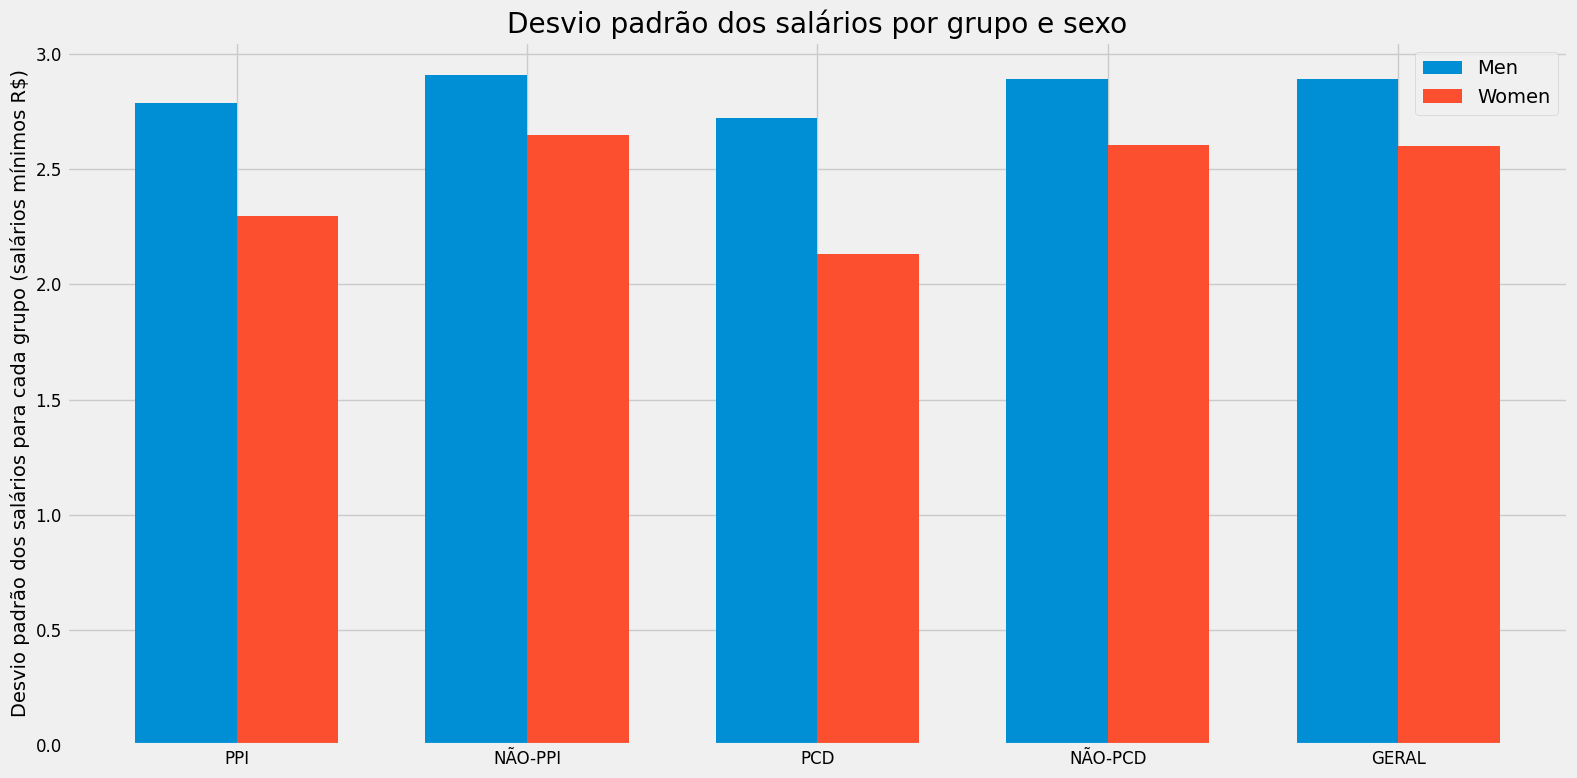

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_std, width, label='Men')
rects2 = ax.bar(x + width/2, women_std, width, label='Women')

ax.set_ylabel('Desvio padrão dos salários para cada grupo (salários mínimos R$)')
ax.set_title('Desvio padrão dos salários por grupo e sexo')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

## Testes de normalidade


### Visuais

#### Distribuição de idades do grupo masculino geral

<ipython-input-33-f7daa8c5f1b2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=male_ages, bins=7)


<Axes: ylabel='Density'>

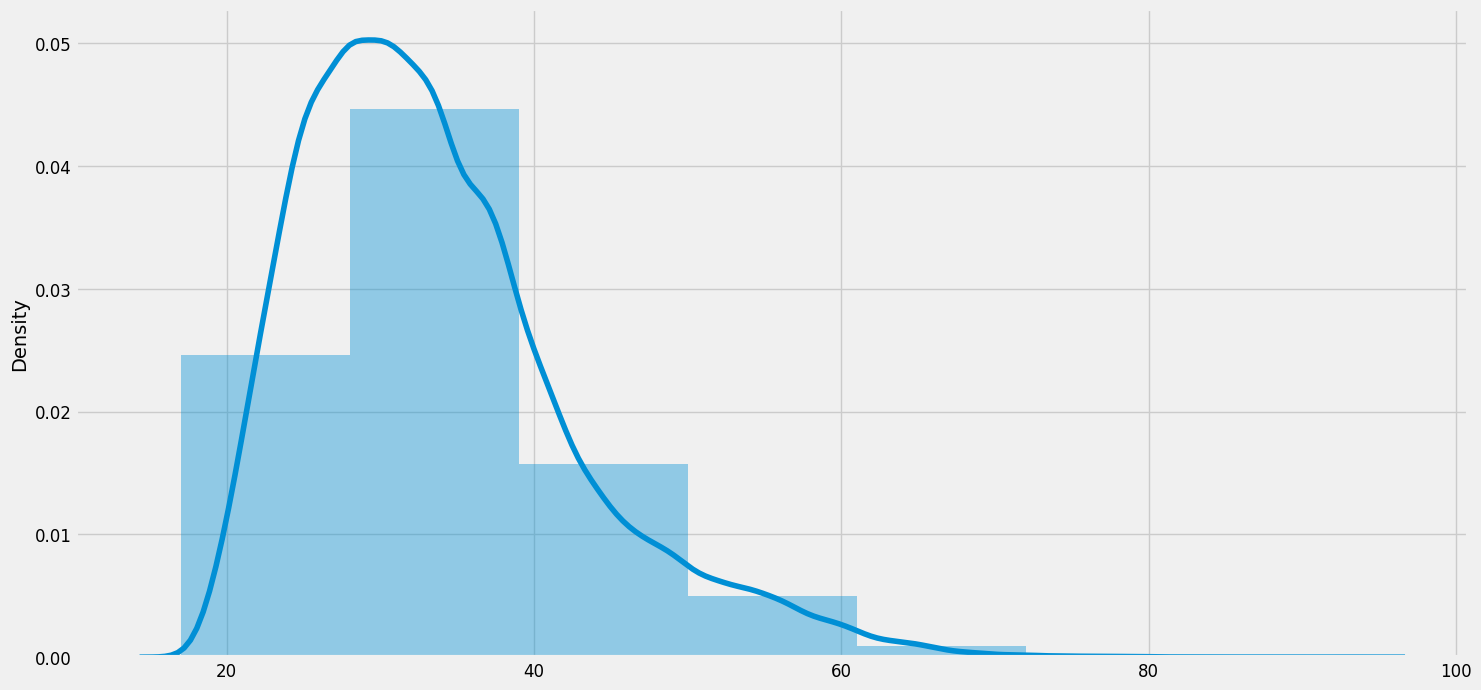

In [ ]:
male_ages = df_male.select("idade").toPandas()
sns.distplot(a=male_ages, bins=7)

#### Distribuição de idades do grupo feminino geral

<ipython-input-34-cd907a977433>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=female_ages, bins=7)


<Axes: ylabel='Density'>

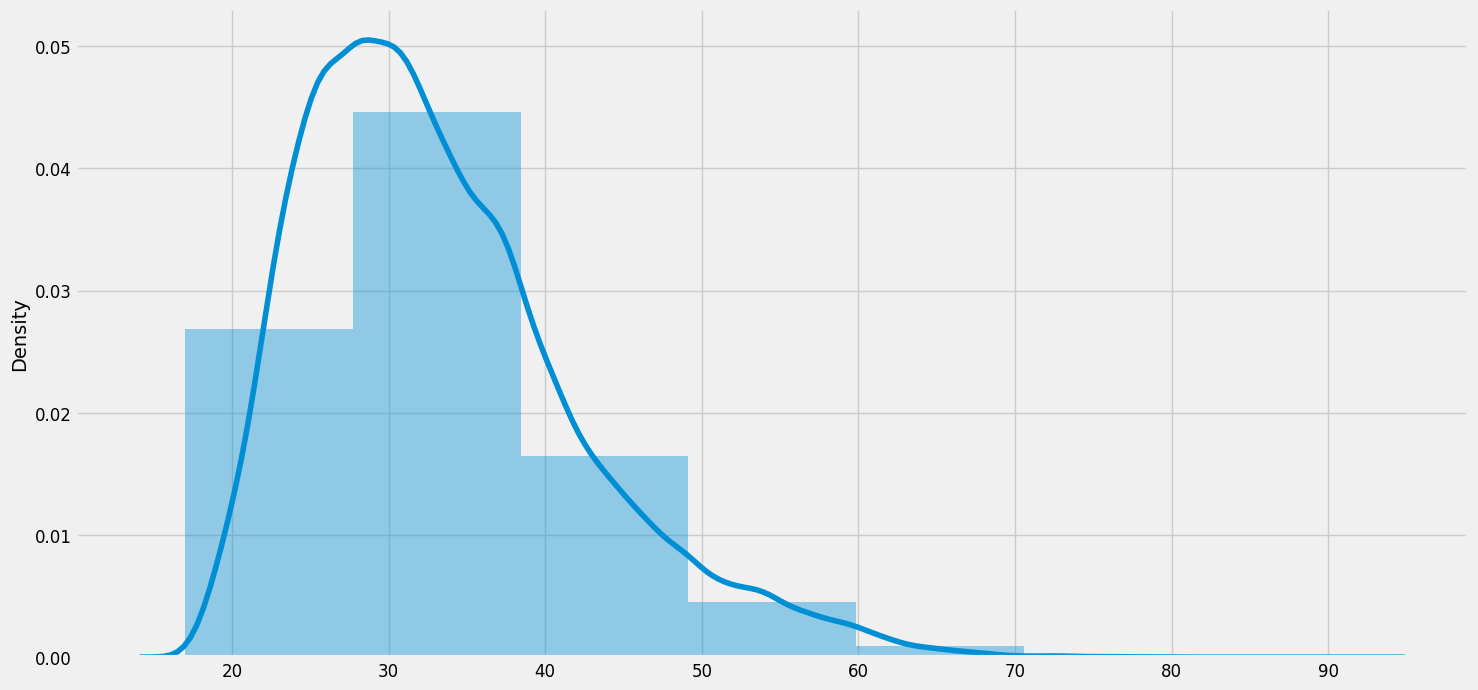

In [ ]:
female_ages = df_female.select("idade").toPandas()
sns.distplot(a=female_ages, bins=7)

### Distribuição salarial geral

Data size: 70991


<ipython-input-24-c828731917bb>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=all_pd_data, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

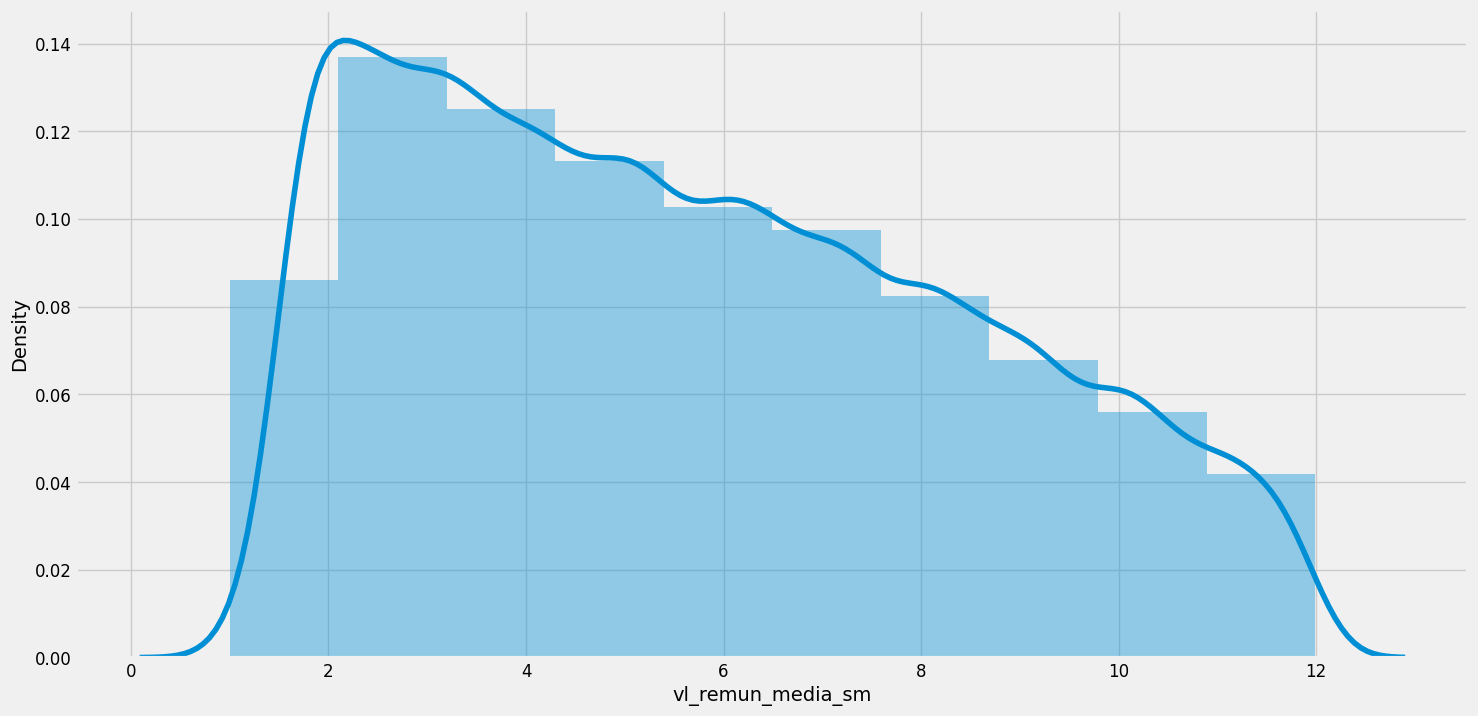

In [ ]:
all_pd_data = pd.concat([i0_data, i1_data, i2_data, i3_data, i4_data, i5_data, i6_data, i7_data])

print("Data size:",len(all_pd_data))

sns.distplot(a=all_pd_data, bins=10)

#### Distribuição salarial do grupo feminino geral

<ipython-input-28-d3254e1e0013>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=dataf, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

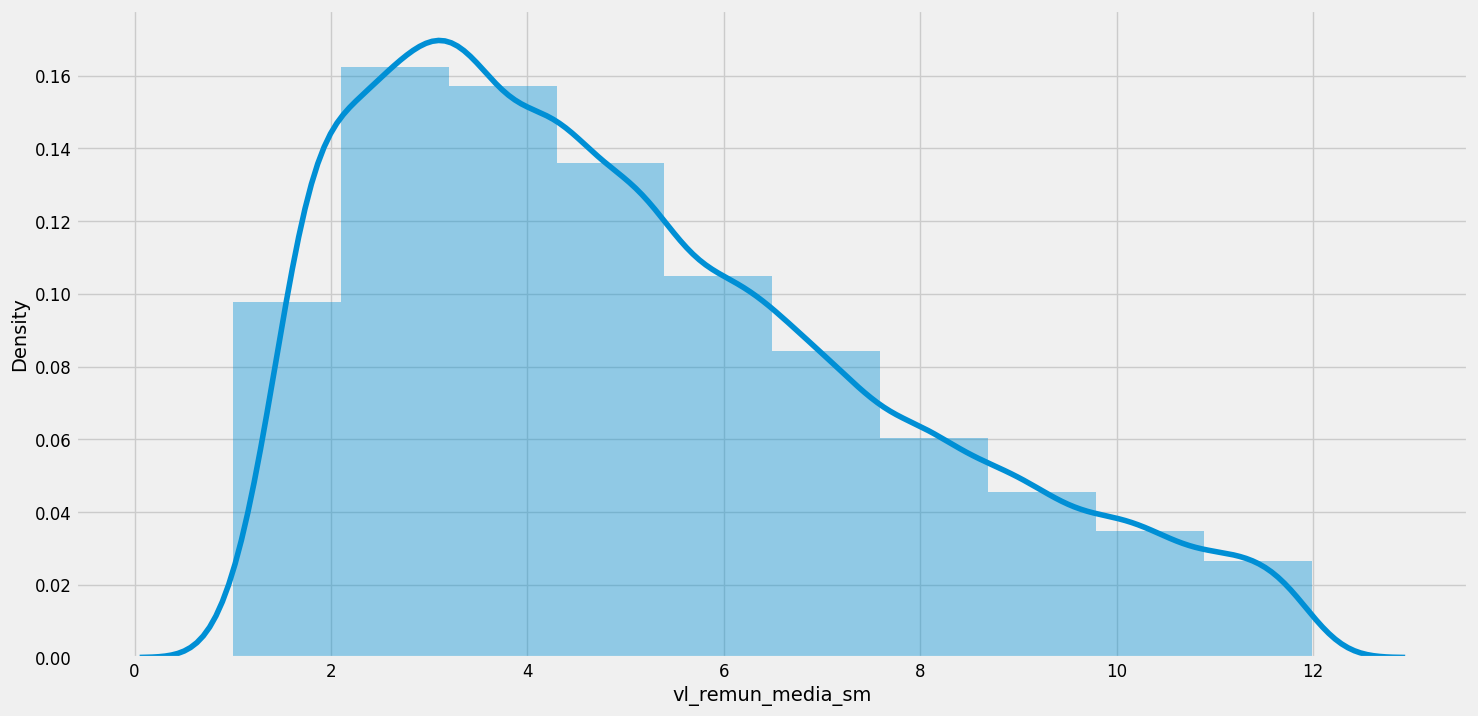

In [ ]:
sns.distplot(a=dataf, bins=10)

#### Distribuição salarial do grupo masculino geral

<ipython-input-29-3a8b9e7707bb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datam, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

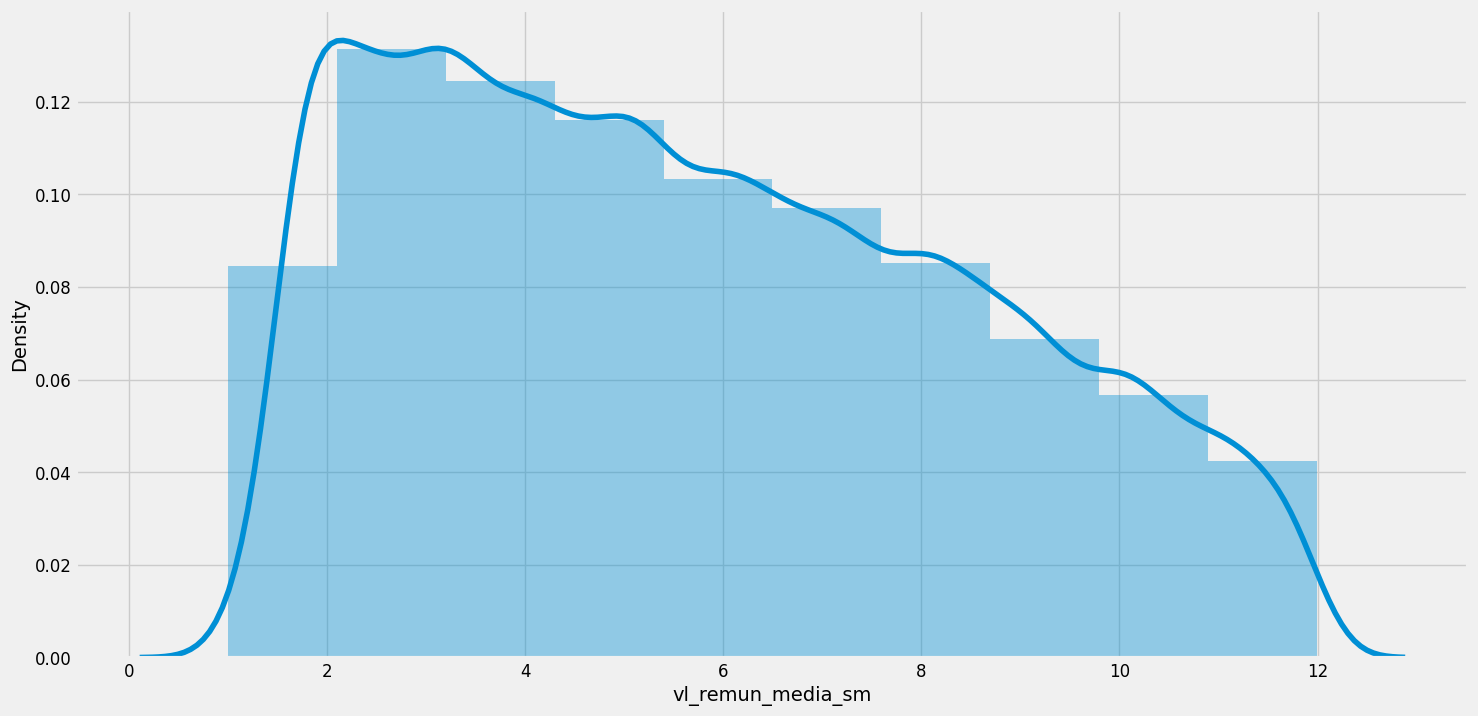

In [ ]:
sns.distplot(a=datam, bins=10)

#### Distribuição salarial do grupo feminino PCD

<ipython-input-37-c83da58ca4fa>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datadf, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

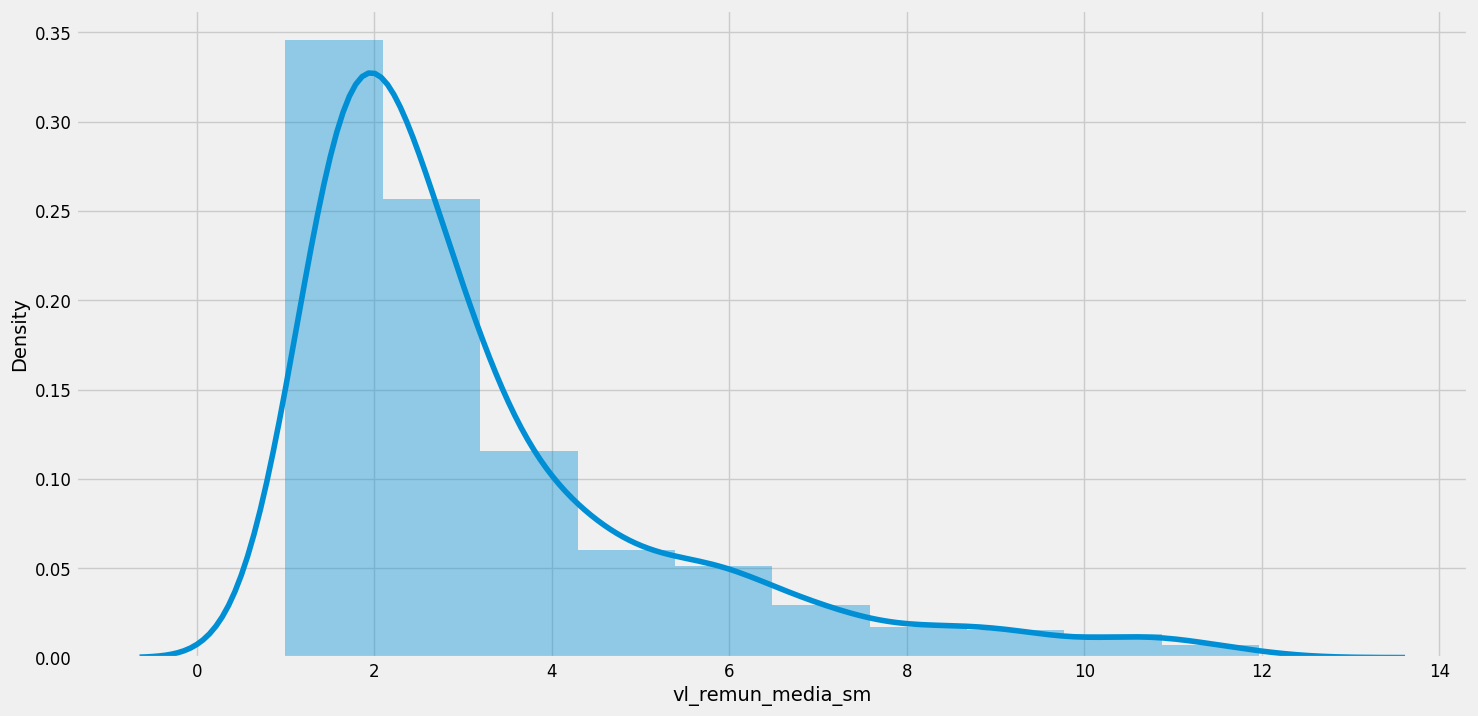

In [ ]:
sns.distplot(a=datadf, bins=10)

#### Distribuição salarial do grupo feminino não-PCD

<ipython-input-38-91c9f3640b5e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datandf, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

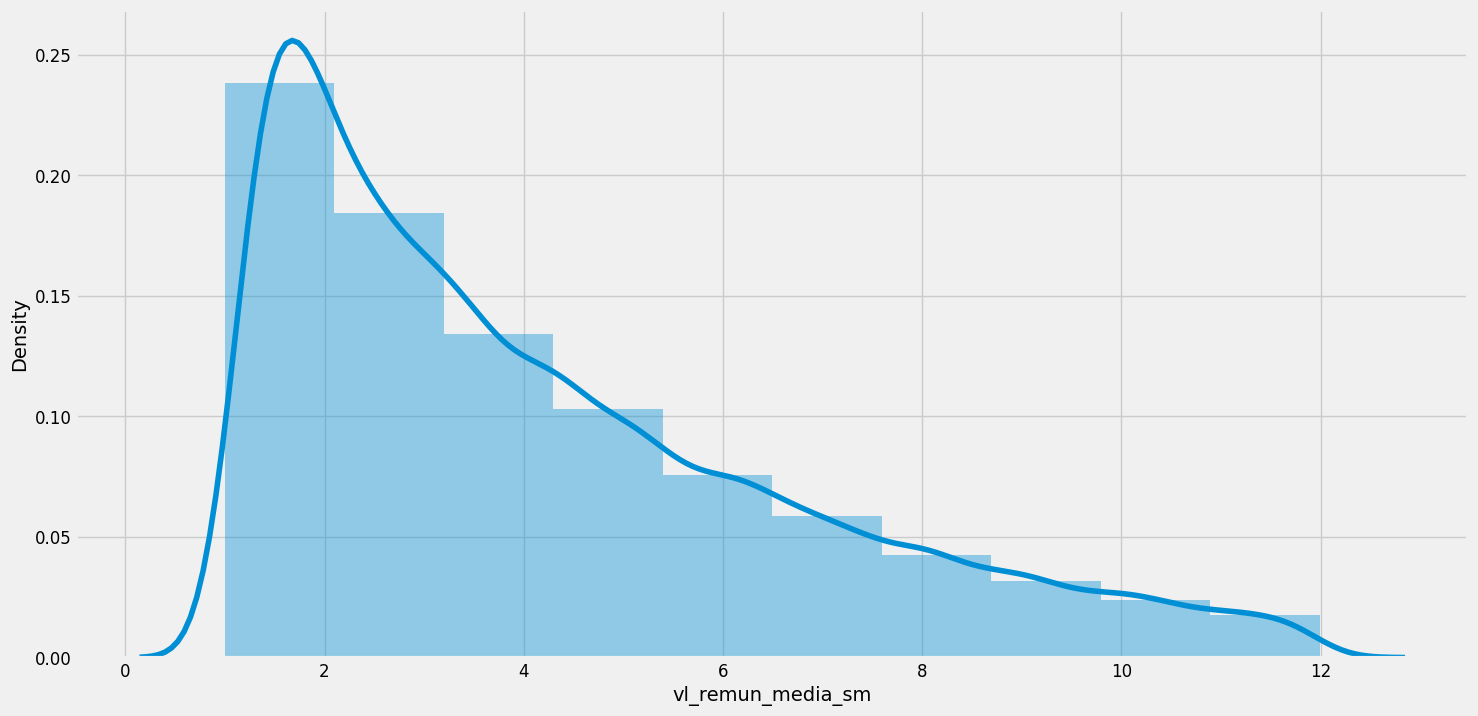

In [ ]:
sns.distplot(a=datandf, bins=10)

#### Distribuição salarial do grupo masculino PCD

<ipython-input-39-0f6c47aab233>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datadm, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

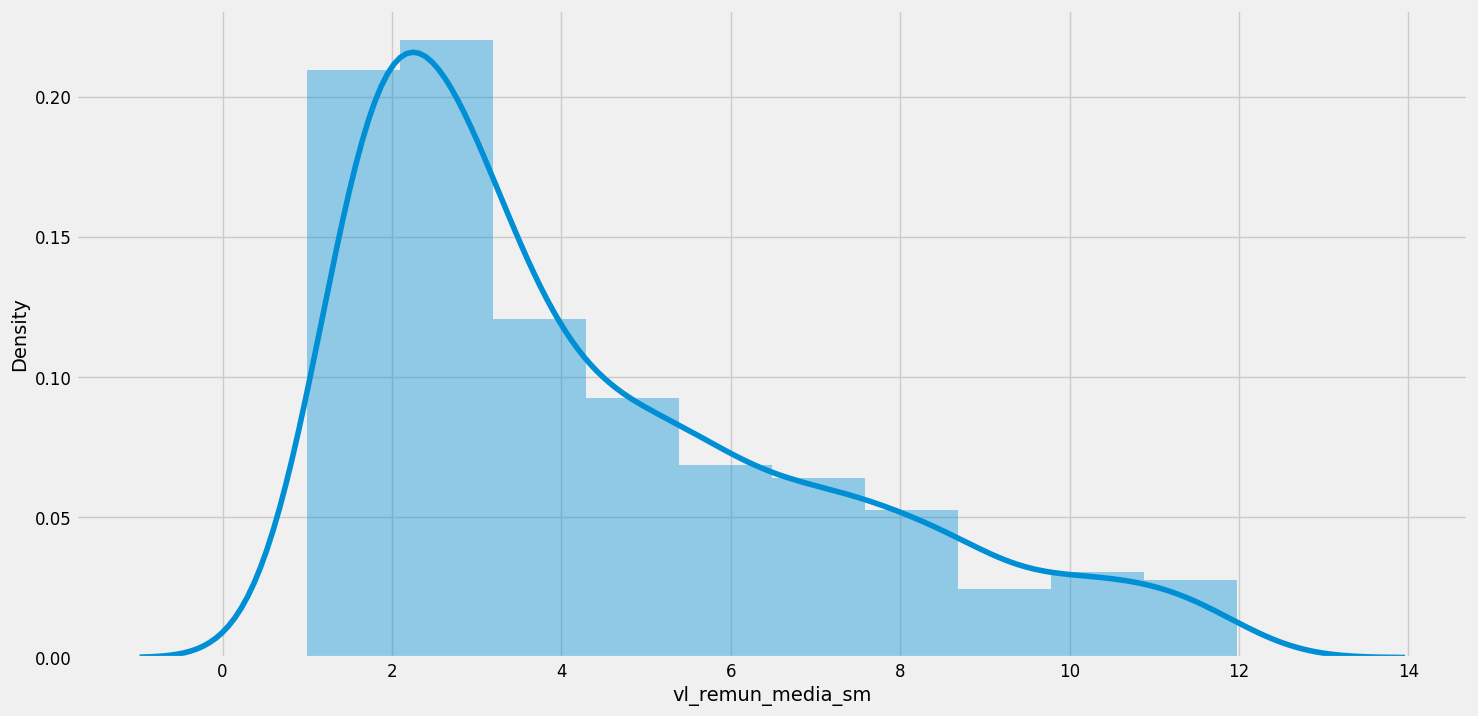

In [ ]:
sns.distplot(a=datadm, bins=10)

#### Distribuição salarial do grupo masculino não-PCD

<ipython-input-40-f2ea716ec2d7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datandm, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

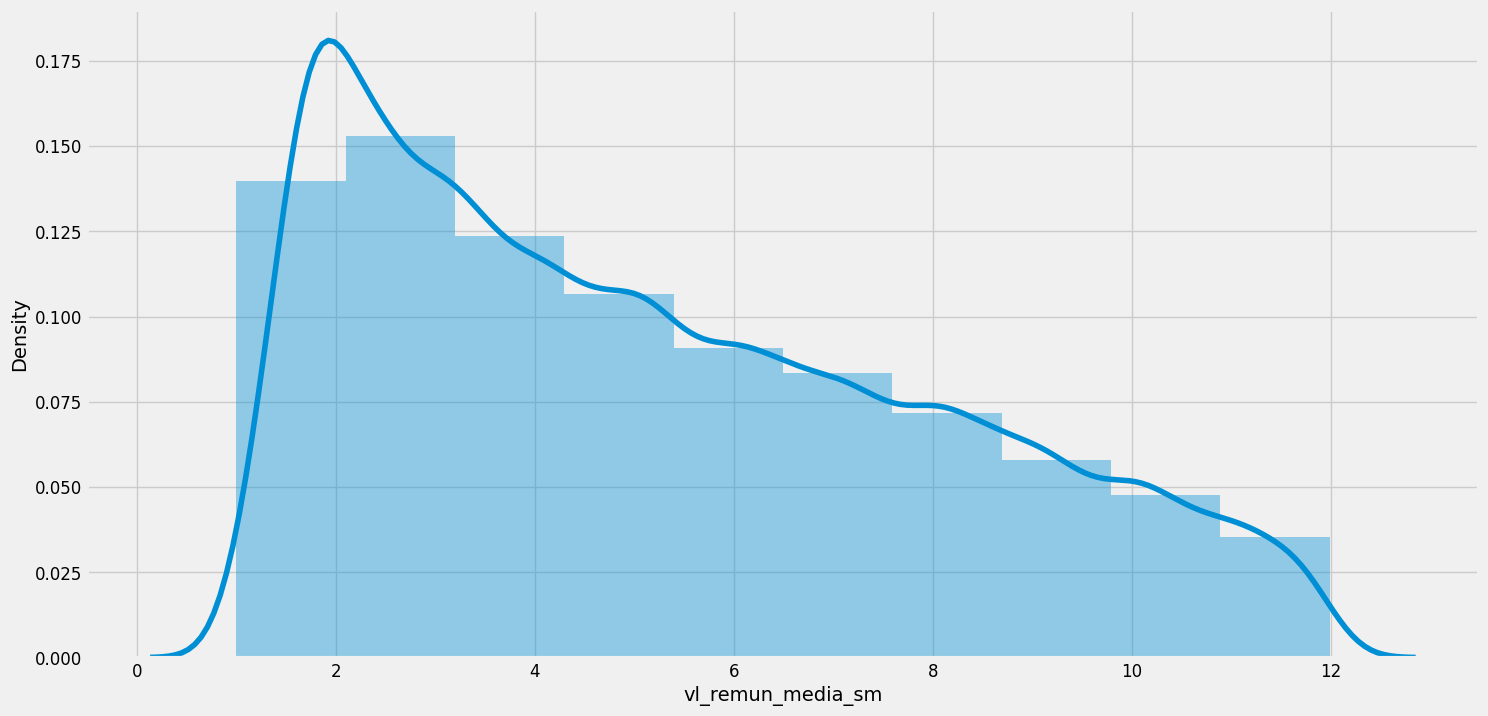

In [ ]:
sns.distplot(a=datandm, bins=10)

#### Distribuição salarial do grupo feminino PPI

<ipython-input-41-f5f99a581898>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datapf, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

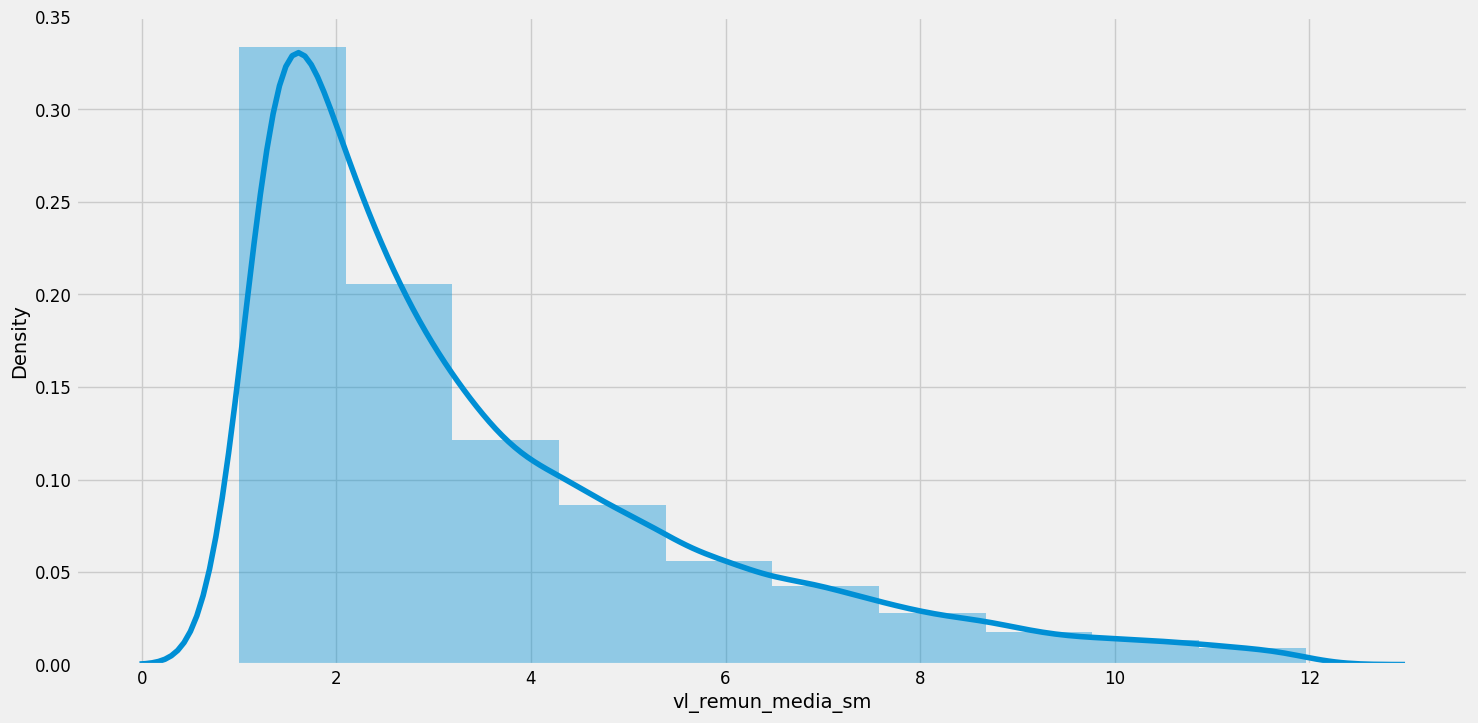

In [ ]:
sns.distplot(a=datapf, bins=10)

#### Distribuição salarial do grupo feminino não-PPI

<ipython-input-42-82c9e55d2f58>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datanpf, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

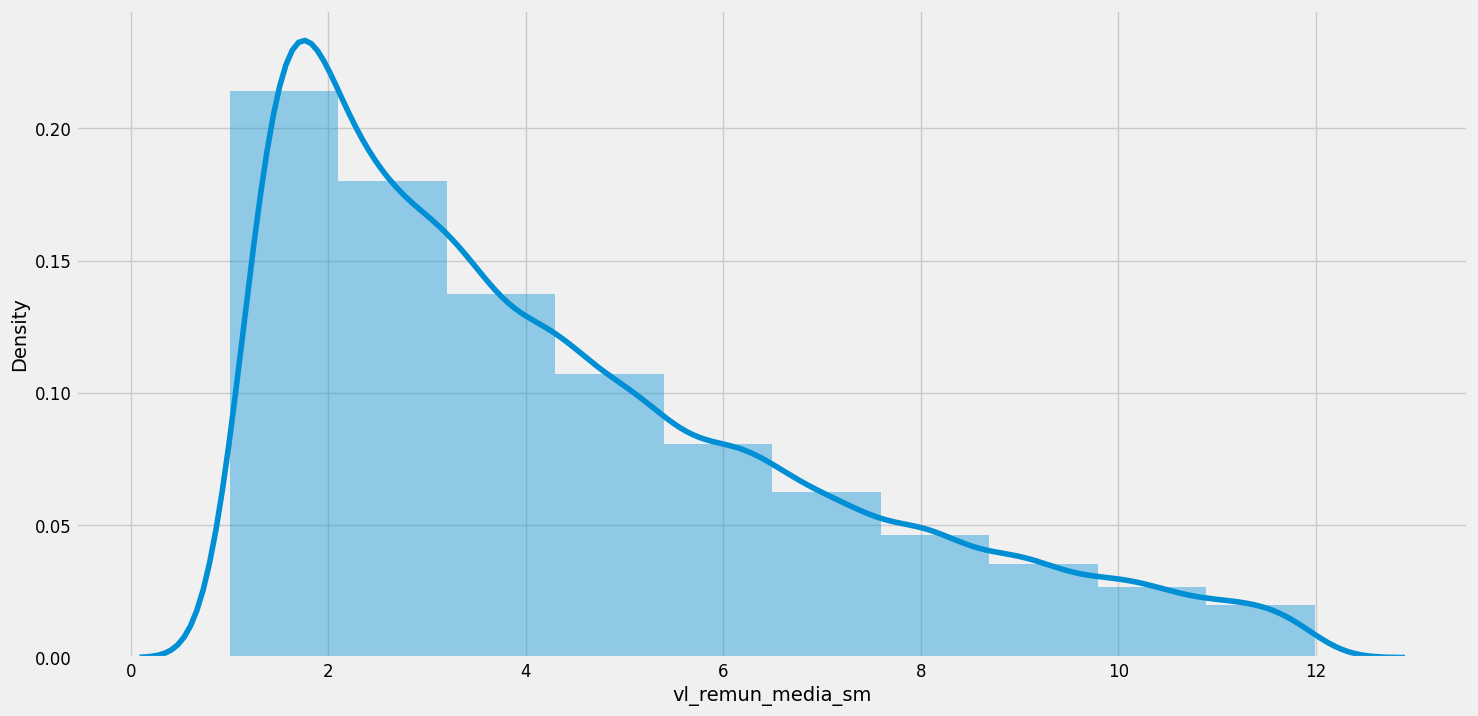

In [ ]:
sns.distplot(a=datanpf, bins=10)

#### Distribuição salarial do grupo masculino PPI

<ipython-input-43-f13b489926c8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datapm, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

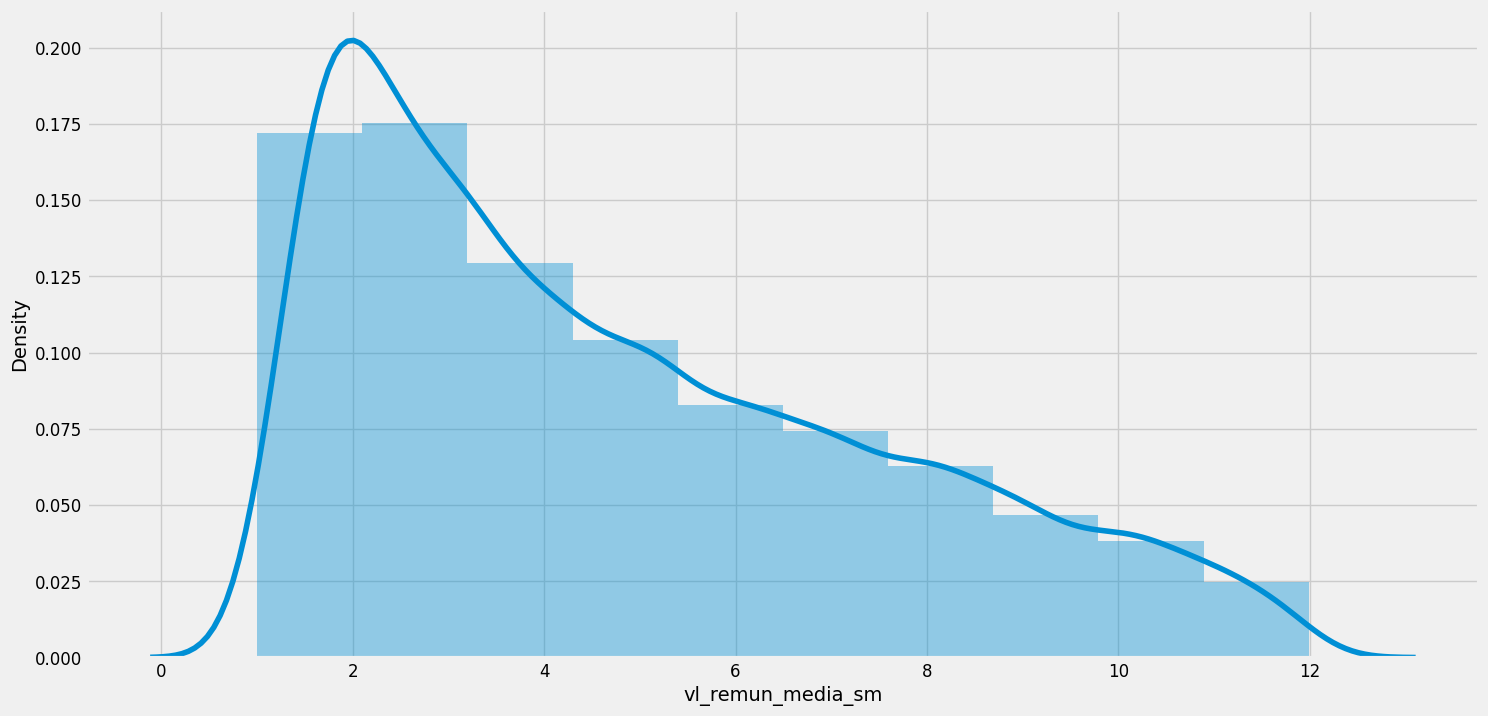

In [ ]:
sns.distplot(a=datapm, bins=10)

#### Distribuição salarial do grupo masculino não-PPI

<ipython-input-44-54d76f9c685f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=datanpm, bins=10)


<Axes: xlabel='vl_remun_media_sm', ylabel='Density'>

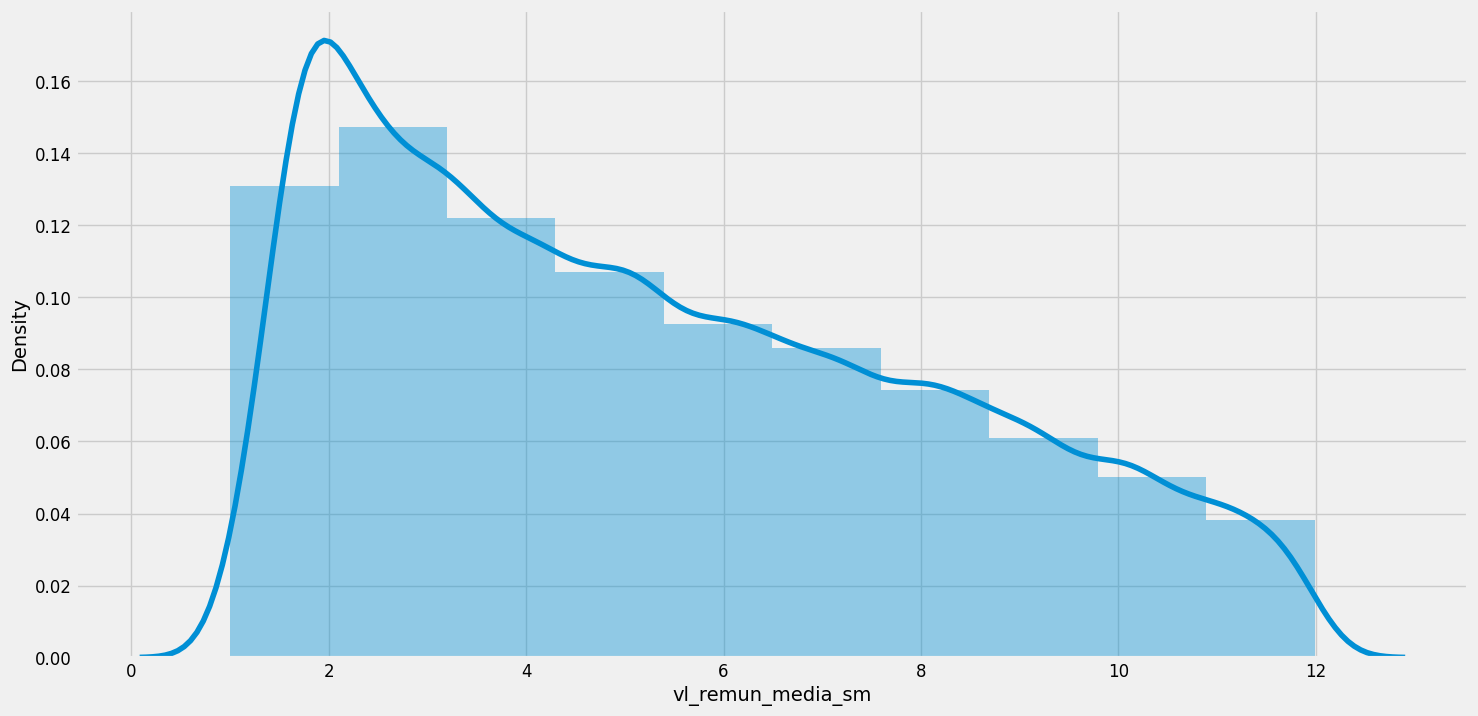

In [ ]:
sns.distplot(a=datanpm, bins=10)

### Numéricos formais

#### Testes Shapiro-Wilk

##### Distribuição de idades do grupo masculino geral

In [ ]:
# shapiro(male_ages)

##### Distribuição de idades do grupo feminino geral

In [ ]:
# shapiro(female_ages)

##### Distribuição salarial do grupo feminino geral

In [ ]:
shapiro(dataf)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8975363373756409, pvalue=0.0)

##### Distribuição salarial do grupo masculino geral

In [ ]:
shapiro(datam)

ShapiroResult(statistic=0.9381155967712402, pvalue=0.0)

##### Distribuição salarial do grupo feminino PCD

In [ ]:
shapiro(datadf)

ShapiroResult(statistic=0.8047211170196533, pvalue=1.8806698853975253e-31)

##### Distribuição salarial do grupo feminino não-PCD

In [ ]:
shapiro(datandf)

ShapiroResult(statistic=0.8986327052116394, pvalue=0.0)

##### Distribuição salarial do grupo masculino PCD

In [ ]:
shapiro(datadm)

ShapiroResult(statistic=0.8888728022575378, pvalue=1.9538742249153225e-28)

##### Distribuição salarial do grupo masculino não-PCD

In [ ]:
shapiro(datandm)

ShapiroResult(statistic=0.9386999607086182, pvalue=0.0)

##### Distribuição salarial do grupo feminino PPI

In [ ]:
shapiro(datapf)

ShapiroResult(statistic=0.8520468473434448, pvalue=0.0)

##### Distribuição salarial do grupo feminino não-PPI

In [ ]:
shapiro(datanpf)

ShapiroResult(statistic=0.9087818264961243, pvalue=0.0)

##### Distribuição salarial do grupo masculino PPI

In [ ]:
shapiro(datapm)

ShapiroResult(statistic=0.9229491353034973, pvalue=0.0)

##### Distribuição salarial do grupo masculino não-PPI

In [ ]:
shapiro(datanpm)

ShapiroResult(statistic=0.942288339138031, pvalue=0.0)

#### Testes Kolmogorov-Smirnov

##### Distribuição de idades do grupo masculino geral

In [ ]:
# kstest(male_ages, 'norm')

##### Distribuição de idades do grupo feminino geral

In [ ]:
# kstest(female_ages, 'norm')

##### Distribuição salarial do grupo feminino geral

In [ ]:
kstest(dataf, 'norm')

KstestResult(statistic=0.863260545416791, pvalue=0.0, statistic_location=1.2, statistic_sign=-1)

##### Distribuição salarial do grupo masculino geral

In [ ]:
kstest(datam, 'norm')

KstestResult(statistic=0.8959289486894323, pvalue=0.0, statistic_location=1.5, statistic_sign=-1)

##### Distribuição salarial do grupo feminino PCD

In [ ]:
kstest(datadf, 'norm')

KstestResult(statistic=0.8619415861498877, pvalue=0.0, statistic_location=1.18, statistic_sign=-1)

##### Distribuição salarial do grupo feminino não-PCD

In [ ]:
kstest(datandf, 'norm')

KstestResult(statistic=0.8633346011041453, pvalue=0.0, statistic_location=1.2, statistic_sign=-1)

##### Distribuição salarial do grupo masculino PCD

In [ ]:
kstest(datadm, 'norm')

KstestResult(statistic=0.883488556045534, pvalue=0.0, statistic_location=1.38, statistic_sign=-1)

##### Distribuição salarial do grupo masuclino não-PCD

In [ ]:
kstest(datandm, 'norm')

KstestResult(statistic=0.8961929079632402, pvalue=0.0, statistic_location=1.5, statistic_sign=-1)

##### Distribuição salarial do grupo feminino PPI

In [ ]:
kstest(datapf, 'norm')

KstestResult(statistic=0.8526692877230981, pvalue=0.0, statistic_location=1.16, statistic_sign=-1)

##### Distribuição salarial do grupo feminino não-PPI

In [ ]:
kstest(datanpf, 'norm')

KstestResult(statistic=0.8667550646091556, pvalue=0.0, statistic_location=1.2, statistic_sign=-1)

##### Distribuição salarial do grupo masculino PPI

In [ ]:
kstest(datapm, 'norm')

KstestResult(statistic=0.8808377216526926, pvalue=0.0, statistic_location=1.29, statistic_sign=-1)

##### Distribuição salarial do grupo masculino não-PPI

In [ ]:
kstest(datanpm, 'norm')

KstestResult(statistic=0.9013485403578901, pvalue=0.0, statistic_location=1.59, statistic_sign=-1)

### Conclusão

#### Idades

A distribuição de idades mostra que o grupo analisado tem, majoritariamente, entre 20 e 40 anos de idade. Isso se dá ao fato de que o grupo somente inclui pessoas que estão cursando algum curso de Ensino Superior, ou já se formaram, ou já possuem algum nível de pós-graduação.

Outro *insight* interessante a respeito da distribuição de idades é que, de acordo com os dados coletados, é mais comum um indivíduo do grupo feminino possuir uma idade mais avançada (mais de 40 anos de idade) em relação ao grupo masculino.

#### Salários

A distribuição salarial de todos os grupos testados NÃO POSSUI distribuição normal.

Como mostrado nos histogramas, a distribuição do salário de todos os grupo é assimétrica com mediana tendendo a ser menor do que a média dos dados.

Além disso, conforme mostrado através dos testes de normalidade numéricos "Shapiro-Wilk" e "Kolmogorov-Smirnov", a distribuição de salário de todos os grupos em questão não possui distribuição normal, sendo que todos os testes resultam em um valor-p menor do que 0.05.

## Testes de Hipóteses Mann-Whitney U


### Grupo feminino geral / masculino geral

#### O grupo feminino possui uma distribuição salarial IGUAL a do grupo masculino

In [ ]:
dataf_size = len(dataf)
datam_size = len(datam)

smaller_size = dataf_size if dataf_size < datam_size else datam_size
smaller_size

# H0 - f == m
# H1 - f != m
stats.mannwhitneyu(x=dataf[: smaller_size - 1], y=datam[: smaller_size - 1], alternative="two-sided") # greater, less

MannwhitneyuResult(statistic=1748266824.5, pvalue=0.0)

#### O grupo feminino possui uma distribuição salarial MAIOR ou igual a do grupo masculino

In [ ]:
# H0 - f >= m
# H1 - f < m
stats.mannwhitneyu(x=dataf[: smaller_size - 1], y=datam[: smaller_size - 1], alternative="less") # greater, less

MannwhitneyuResult(statistic=1748266824.5, pvalue=0.0)

#### O grupo feminino possui uma distribuição salarial MENOR ou igual a do grupo masculino

In [ ]:
# H0 - f <= m
# H1 - f > m
stats.mannwhitneyu(x=dataf[: smaller_size - 1], y=datam[: smaller_size - 1], alternative="greater") # greater, less

MannwhitneyuResult(statistic=1748266824.5, pvalue=1.0)

#### Conclusão
Para testes com nível de significância igual à 0.05:

**Com base nesses dados, temos evidências o suficiente para afirmar que a distribuição salarial do grupo feminino tende a ser menor do que a distribuição salarial do grupo masculino.**

Na primeira célula de código, com o teste bilateral, é mostrado que a distribuição dos dois grupos é diferente (valor-p menor do que 0.05, REJEITANDO a hipótese nula). Mas, por si só, isso não confirma que a distribuição do grupo feminino seja menor que a do masculino.

Na segunda célula de código, com o teste unilateral para a esquerda, temos o valor-p também menor do que 0.05, o que nos faz REJEITAR a hipótese nula. Com isso, fica a confirmação de que o grupo feminino possui distribuição salarial menor do que a do grupo masculino.

Na terceira célula de código, com o teste unilateral para a direita, temos o valor-p maior do que 0.05, o que nos faz ACEITAR a hipótese nula. Com isso, temos mais uma forma de confirmação de que o grupo feminino possui distribuição salarial menor do que a do grupo masculino.

### Grupo masculino PCD / feminino PCD



#### O salário do grupo masculino PCD possui distribuição salarial IGUAL a do grupo feminino PCD

In [ ]:
datadf_size = len(datadf)
datadm_size = len(datadm)
smaller_size = datadf_size if datadf_size < datadm_size else datadm_size

# H0 - m == f
# H1 - m != f
stats.mannwhitneyu(x=datadm[: smaller_size - 1], y=datadf[: smaller_size - 1], alternative="two-sided")

MannwhitneyuResult(statistic=474375.0, pvalue=1.0058504142252284e-12)

#### O salário do grupo masculino PCD possui distribuição salarial MAIOR ou igual a do grupo feminino PCD

In [ ]:
# H0 - m >= f
# H1 - m < f
stats.mannwhitneyu(x=datadm[: smaller_size - 1], y=datadf[: smaller_size - 1], alternative="less")

MannwhitneyuResult(statistic=474375.0, pvalue=0.9999999999994974)

#### O salário do grupo masculino PCD possui distribuição salarial MENOR ou igual a do grupo feminino PCD

In [ ]:
# H0 - m <= f
# H1 - m > f
stats.mannwhitneyu(x=datadm[: smaller_size - 1], y=datadf[: smaller_size - 1], alternative="greater")

MannwhitneyuResult(statistic=474375.0, pvalue=5.029252071126142e-13)

#### Conclusão
Para testes com nível de significância igual à 0.05:

**Com base nesses dados, temos evidências o suficiente para afirmar que a distribuição salarial de ambos os grupos é aproximadamente igual. Porém, também é plausível assumir a possibilidade de que o grupo masculino tende a uma distribuição levemente maior.**

Na primeira célula de código, com o teste bilateral, é mostrado que a distribuição dos dois grupos é aproximadamente (valor-p menor do que 0.05, ACEITANDO a hipótese nula). Mas, por si só, isso não diz que a distribuição de ambos os grupos é de fato igual e sem disparidades.

Na segunda célula de código, com o teste unilateral para a esquerda, temos o valor-p também maior do que 0.05 (nesse caso, por muito), o que nos faz ACEITAR a hipótese nula. Com isso, fica a confirmação de que a distribuição salarial entre ambos os grupos é aproximadamente igual. Porém, dado que o valor-p é muito mais próximo do 1 do que é do 0, é plausível assumir a possibilidade de que o grupo masculino possua uma distribuição de salário maior do que a do grupo feminino, apesar de que, com base nos testes realizados, não podemos afirmar.

Na terceira célula de código, com o teste unilateral para a direita, temos o valor-p também maior do que 0.05 (apesar de que está mais próximo do nível de significância), o que nos faz ACEITAR a hipótese nula. Com isso, temos mais uma forma de confirmação de que a distribuição salarial de ambos os grupos é aproximadamente igual, apesar de que, pela mesma razão da análise da segunda célula de código, porém, com proximidade maior do 0 do que do 1, é plausível também assumir a possibilidade de que o grupo masculino possua uma distribuição de salário maior do que a do grupo feminino, apesar de que, com base nos testes realizados, não podemos afirmar.

Note que os valores-p da segunda e terceira célula são complementares.

### Grupo masculino PPI / feminino PPI

#### O grupo masculino PPI possui uma distribuição salarial IGUAL a do grupo feminino PPI

In [ ]:
datapm_size = len(datapm)
datapf_size = len(datapf)
smaller_size = datapf_size if datapf_size < datapm_size else datapm_size

# H0 - m == f
# H1 - m != f
stats.mannwhitneyu(x=datapm[: smaller_size - 1], y=datapf[: smaller_size - 1], alternative="two-sided")

MannwhitneyuResult(statistic=119196346.0, pvalue=8.760444267031063e-234)

#### O grupo masculino PPI possui uma distribuição salarial MAIOR ou igual a do grupo feminino PPI

In [ ]:
# H0 - m >= f
# H1 - m <  f
stats.mannwhitneyu(x=datapm[: smaller_size - 1], y=datapf[: smaller_size - 1], alternative="less")

MannwhitneyuResult(statistic=119196346.0, pvalue=1.0)

#### O grupo masculino PPI possui uma distribuição salarial MENOR ou igual a do grupo feminino PPI

In [ ]:
# H0 - m <= f
# H1 - m >  f
stats.mannwhitneyu(x=datapm[: smaller_size - 1], y=datapf[: smaller_size - 1], alternative="greater")

MannwhitneyuResult(statistic=119196346.0, pvalue=4.3802221335155313e-234)

#### Conclusão
Para testes com nível de significância igual à 0.05:

**Com base nesses dados, temos evidências o suficiente para afirmar que a distribuição salarial do grupo masculino PPI tende a ser maior do que a distribuição salarial do grupo feminino PPI.**

Na primeira célula de código, com o teste bilateral, é mostrado que a distribuição dos dois grupos é diferente (valor-p menor do que 0.05, REJEITANDO a hipótese nula). Mas, por si só, isso não confirma que a distribuição do grupo masculino PPI seja menor que a do feminino PPI.

Na segunda célula de código, com o teste unilateral para a esquerda, temos o valor-p maior do que 0.05, o que nos faz ACEITAR a hipótese nula. Com isso, fica a confirmação de que o grupo masculino PPI possui uma distribuição maior ou igual do que a do grupo feminino PPI.

Na terceira célula de código, com o teste unilateral para a direita, temos o valor-p menor do que 0.05, o que nos faz REJEITAR a hipótese nula. Com isso, temos mais uma forma de confirmação de que o grupo masculino PPI possui distribuição salarial menor do que a do grupo feminino PPI.

### Grupo PCD / não-PCD

#### O grupo PCD possui uma distribuição salarial IGUAL a do grupo não PCD

In [ ]:
#data_defic_size = len(data_defic)
#data_non_defic_size = len(data_non_defic)
#smaller_size = data_defic_size if data_defic_size < data_non_defic_size else data_non_defic_size
#
## H0 - pcd == not-pcd
## H1 - pcd != not-pcd
#stats.mannwhitneyu(x=data_defic[: smaller_size - 1], y=data_non_defic[: smaller_size - 1], alternative="two-sided")

#### O grupo PCD possui uma distribuição salarial MAIOR ou igual a do grupo não PCD

In [ ]:
## H0 - pcd >= not-pcd
## H1 - pcd <  not-pcd
#stats.mannwhitneyu(x=data_defic[: smaller_size - 1], y=data_non_defic[: smaller_size - 1], alternative="less")

#### O grupo PCD possui uma distribuição salarial MENOR ou igual a do grupo não PCD

In [ ]:
## H0 - pcd <= not-pcd
## H1 - pcd >  not-pcd
#stats.mannwhitneyu(x=data_defic[: smaller_size - 1], y=data_non_defic[: smaller_size - 1], alternative="greater")

#### Tem alguma coisa estranha aqui

### Grupo PPI / não-PPI

#### O grupo PPI possui uma distribuição salarial IGUAL a do grupo não PPI

In [ ]:
#data_poc_size = len(data_poc)
#data_non_poc_size = len(data_non_poc)
#smaller_size = data_poc_size if data_poc_size < data_non_poc_size else data_non_poc_size#
## H0 - ppi == not-ppi
## H1 - ppi != not-ppi
#stats.mannwhitneyu(x=data_poc[: smaller_size - 1], y=data_non_poc[: smaller_size - 1], alternative="two-sided")

#### O grupo PPI possui uma distribuição salarial MAIOR ou igual a do grupo não PPI

In [ ]:
## H0 - ppi >= not-ppi
## H1 - ppi <  not-ppi
#stats.mannwhitneyu(x=data_poc[: smaller_size - 1], y=data_non_poc[: smaller_size - 1], alternative="less")

#### O grupo PPI possui uma distribuição salarial MENOR ou igual a do grupo não PPI geral

In [ ]:
## H0 - ppi <= not-ppi
## H1 - ppi >  not-ppi
#stats.mannwhitneyu(x=data_poc[: smaller_size - 1], y=data_non_poc[: smaller_size - 1], alternative="greater")

#### Conclusão
Para testes com nível de significância igual à 0.05:

**Com base nesses dados, temos evidências o suficiente para afirmar que a distribuição salarial do grupo PPI geral tende a ser menor do que a distribuição salarial do grupo não-PPI geral.**

Na primeira célula de código, com o teste bilateral, é mostrado que a distribuição dos dois grupos é diferente (valor-p menor do que 0.05, REJEITANDO a hipótese nula). Mas, por si só, isso não confirma que a distribuição do grupo masculino PPI seja menor que a do feminino PPI.

Na segunda célula de código, com o teste unilateral para a esquerda, temos o valor-p maior do que 0.05, o que nos faz ACEITAR a hipótese nula. Com isso, fica a confirmação de que o grupo masculino PPI possui uma distribuição maior ou igual do que a do grupo feminino PPI.

Na terceira célula de código, com o teste unilateral para a direita, temos o valor-p menor do que 0.05, o que nos faz REJEITAR a hipótese nula. Com isso, temos mais uma forma de confirmação de que o grupo masculino PPI possui distribuição salarial menor do que a do grupo feminino PPI.

### Grupo PCD-não-PPI / PPI-não-PCD

Não sei se esse teste de hipótese seria muito útil sem a segregação para os grupos masculino e feminino, considerando que o grupo feminino por si só já é marginalizado. Talvez separar esses grupos seja o ideal.

#### O grupo PPI que não é PCD possui distribuição IGUAL a do grupo PCD que não é PPI

In [ ]:
#data_poc_non_defic_size = len(data_poc)
#data_defic_non_poc_size = len(data_non_poc)
#smaller_size = data_poc_non_defic_size if data_poc_non_defic_size < data_defic_non_poc_size else data_defic_non_poc_size
#
## H0 - ppi-non-defic == defic-not-ppi
## H1 - ppi-non-defic != defic-not-ppi
#stats.mannwhitneyu(x=poc_non_defic_data[: smaller_size - 1], y=defic_non_poc_data[: smaller_size - 1], alternative="two-sided")

#### O grupo PPI que não é PCD possui distribuição MAIOR ou igual a do grupo PCD que não é PPI

In [ ]:
## H0 - ppi-non-defic >= defic-not-ppi
## H1 - ppi-non-defic <  defic-not-ppi
#stats.mannwhitneyu(x=poc_non_defic_data[: smaller_size - 1], y=defic_non_poc_data[: smaller_size - 1], alternative="less")

#### O grupo PPI que não é PCD possui distribuição MENOR ou igual a do grupo PCD que não é PPI

In [ ]:
## H0 - ppi-non-defic <= defic-not-ppi
## H1 - ppi-non-defic >  defic-not-ppi
#stats.mannwhitneyu(x=poc_non_defic_data[: smaller_size - 1], y=defic_non_poc_data[: smaller_size - 1], alternative="greater")

#### Conclusão
Para testes com nível de significância igual à 0.05:

**Com base nesses dados, temos evidências o suficiente para afirmar que a distribuição salarial do grupo PPI-não-PCD tende a ser menor do que a distribuição salarial do grupo PCD-não-PPI, apesar de que a distribuição tende a ser semelhante.**

Na primeira célula de código, com o teste bilateral, é mostrado que a distribuição dos dois grupos é diferente (valor-p menor do que 0.05, REJEITANDO a hipótese nula). Mas, por si só, isso não confirma que a distribuição do grupo masculino PPI seja menor que a do feminino PPI.

Na segunda célula de código, com o teste unilateral para a esquerda, temos o valor-p maior do que 0.05, o que nos faz ACEITAR a hipótese nula. Com isso, fica a confirmação de que o grupo masculino PPI possui uma distribuição maior ou igual do que a do grupo feminino PPI.

Na terceira célula de código, com o teste unilateral para a direita, temos o valor-p menor do que 0.05, o que nos faz REJEITAR a hipótese nula. Com isso, temos mais uma forma de confirmação de que o grupo masculino PPI possui distribuição salarial menor do que a do grupo feminino PPI.


## Testes de hipótese com segregações exclusivas

Grupos ABCD >= EFGH

Masculino vs. Feminino

Não-PCD vs. PCD

Não-PPI vs. PPI

In [ ]:
print("\nMale x Female\n")

smaller = len(i4_data)
res = stats.mannwhitneyu(x=i0_data[: smaller], y=i4_data[: smaller], alternative="less")
print(f"A >= E: [statistic={res.statistic}, pvalue={res.pvalue}]", ) # greater, less

smaller = len(i5_data)
res = stats.mannwhitneyu(x=i1_data[: smaller], y=i5_data[: smaller], alternative="less")
print(f"B >= F: [statistic={res.statistic}, pvalue={res.pvalue}]", ) # greater, less

smaller = len(i6_data)
res = stats.mannwhitneyu(x=i2_data[: smaller], y=i6_data[: smaller], alternative="less")
print(f"C >= G: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i7_data)
res = stats.mannwhitneyu(x=i3_data[: smaller], y=i7_data[: smaller], alternative="less")
print(f"D >= H: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

print("\nNot handicapped x Handicapped\n")

smaller = len(i2_data)
res = stats.mannwhitneyu(x=i0_data[: smaller], y=i2_data[: smaller], alternative="less")
print(f"A >= C: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i3_data)
res = stats.mannwhitneyu(x=i1_data[: smaller], y=i3_data[: smaller], alternative="less")
print(f"B >= D: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i6_data)
res = stats.mannwhitneyu(x=i4_data[: smaller], y=i6_data[: smaller], alternative="less")
print(f"E >= G: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i7_data)
res = stats.mannwhitneyu(x=i5_data[: smaller], y=i7_data[: smaller], alternative="less")
print(f"F >= H: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

print(f"\nWhite-Yellow x Black-Brown-Indigenous\n")

smaller = len(i1_data)
res = stats.mannwhitneyu(x=i0_data[: smaller], y=i1_data[: smaller], alternative="less")
print(f"A >= B: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i3_data)
res = stats.mannwhitneyu(x=i2_data[: smaller], y=i3_data[: smaller], alternative="less")
print(f"C >= D: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i5_data)
res = stats.mannwhitneyu(x=i4_data[: smaller], y=i5_data[: smaller], alternative="less")
print(f"E >= F: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less

smaller = len(i7_data)
res = stats.mannwhitneyu(x=i6_data[: smaller], y=i7_data[: smaller], alternative="less")
print(f"G >= H: [statistic={res.statistic}, pvalue={res.pvalue}]") # greater, less


Male x Female

A >= E: [statistic=77382722.0, pvalue=1.0]
B >= F: [statistic=5886390.0, pvalue=0.9999999999862057]
C >= G: [statistic=5080.5, pvalue=0.8903868548785807]
D >= H: [statistic=700.0, pvalue=0.9943157559919337]

Not handicapped x Handicapped

A >= C: [statistic=56032.0, pvalue=0.0037567051200371147]
B >= D: [statistic=2932.5, pvalue=0.07912530969282994]
E >= G: [statistic=4020.0, pvalue=0.06350430383651616]
F >= H: [statistic=649.0, pvalue=0.9675785252716825]

White-Yellow x Black-Brown-Indigenous

A >= B: [statistic=93512304.0, pvalue=0.9999991456849036]
C >= D: [statistic=3388.0, pvalue=0.5347255306035554]
E >= F: [statistic=5795580.0, pvalue=0.9999999780389461]
G >= H: [statistic=676.5, pvalue=0.9866416617944006]


In [ ]:
pd_comp_df = comp_df.toPandas()

In [ ]:
print("Unique CBO:", pd.unique(pd_comp_df["cbo_ocupacao_2002"]))
print("Unique CNAE:", pd.unique(pd_comp_df["cnae_20_classe"]))

print("Unique CBO length:", len(pd.unique(pd_comp_df["cbo_ocupacao_2002"])))
print("Unique CNAE length:", len(pd.unique(pd_comp_df["cnae_20_classe"])))

Unique CBO: ['212320' '212405' '212410' '212310' '212420' '212215' '212205' '212315'
 '212305' '212415' '212210']
Unique CNAE: ['62023' '62091' '63194' '62040' '62031' '63119' '58131' '62015' '61302'
 '61906' '59111' '58298' '63992' '61108' '58239' '58123' '59201' '60217'
 '58115' '58221' '63917' '61205' '60101' '59138' '59146' '58212' '58191'
 '60225' '61434' '61418' '59120']
Unique CBO length: 11
Unique CNAE length: 31


<BarContainer object of 11 artists>

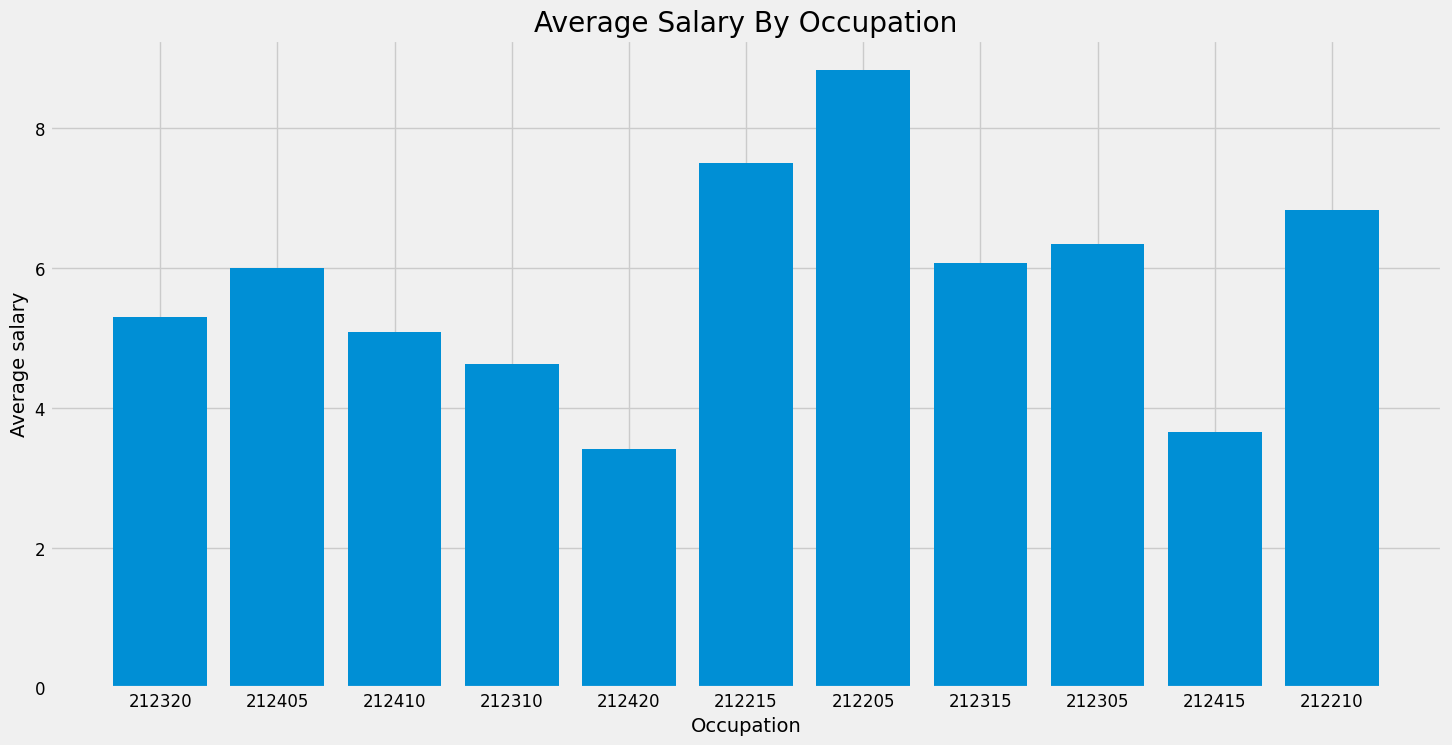

In [ ]:
values = pd.unique(pd_comp_df["cbo_ocupacao_2002"])

x = []
y = []
for i in values:
  tmp = pd_comp_df.loc[pd_comp_df["cbo_ocupacao_2002"] == i, ["vl_remun_media_sm"]]
  x.append(str(i))
  y.append(tmp["vl_remun_media_sm"].median())

# plot

plt.title("Average Salary By Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average salary")

plt.bar(x, y)

### Conclusão geral

O grupo feminino no geral é marginalizado independentemente de quaisquer outros fatores, e tal marginalização tende a se intensificar quando o individuo também faz parte do grupo PPI e/ou PCD. Com base nas analises realizadas, temos a confirmação estatística dos boxplots gerados anteriormente, com consideração dos grupos segregados com isolamento, em ordem do grupo mais prejudicado para o menos prejudicado:

1.   Mulher PCD e PPI (Índice 7)
2.   Mulher não-PCD e PPI* (Índice 5)
3.   Homem PCD e PPI* (Índice 3)
4.   Mulher PCD e não-PPI (Índice 6)
5.   Mulher não-PCD e não-PPI (Índice 4)
6.   Homem não-PCD e PPI (Índice 1)
7.   Homem PCD e não-PPI (Índice 2)
8.   Homem não-PCD e não-PPI (Índice 0)


\* Índice 5 e Índice 3 são muito próximos, porém, o Índice 5 possui um terceiro quartil levemente mais baixo.